In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd
import os
#import dustmaps

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/'

In [3]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

Load in the MUSE FITS file

In [4]:
muse_fits = fits.open(rootdir + 'COMBINED_CUBE_MED_FINAL_vac.fits')

In [5]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [6]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

Extract the MUSE cube as a 3-D array

In [7]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [8]:
#spec_cube.shape, var_cube.shape

Extract the wavelength array

In [9]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [10]:
wav_arr = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)

In [11]:
wav_0, del_wav, (spec_cube.shape[0]-1)

(4751.284541786687, 1.25, 3681)

Extract the RA array

In [12]:
RA_ref_pix = data_hdu.header['CRPIX1']-1
RA_ref_val = data_hdu.header['CRVAL1']
del_RA = data_hdu.header['CD1_1']

In [13]:
del_RA

-5.55555555555556e-05

In [14]:
RA_0_val = RA_ref_val - del_RA*RA_ref_pix

In [15]:
RA_arr = np.arange(RA_0_val, RA_0_val + spec_cube.shape[2]*del_RA, del_RA)

In [16]:
RA_arr_deg = [Angle(ra, units.degree) for ra in RA_arr]

In [17]:
RA_arr_hms = [ra.hms for ra in RA_arr_deg]

In [18]:
RA_arr_labels = [str(int(ra[0])) + 'h' + str(int(ra[1])) + 'm' + str(np.round(ra[2],2)) + 's' 
                 for ra in RA_arr_hms]

Extract Dec array

In [19]:
Dec_ref_pix = data_hdu.header['CRPIX2']-1
Dec_ref_val = data_hdu.header['CRVAL2']
del_Dec = data_hdu.header['CD2_2']

In [20]:
del_Dec

5.55555555555556e-05

In [21]:
Dec_0_val = Dec_ref_val - del_Dec*Dec_ref_pix

In [22]:
Dec_arr = np.arange(Dec_0_val, Dec_0_val + spec_cube.shape[1]*del_Dec, del_Dec)

In [23]:
Dec_arr_deg = [Angle(dec, units.degree) for dec in Dec_arr]

In [24]:
Dec_arr_dms = [dec.dms for dec in Dec_arr_deg]

In [25]:
Dec_arr_labels = [str(int(dec[0])) + 'd' + str(int(dec[1])) + 'm' + str(np.round(dec[2],2)) + 's' 
                 for dec in Dec_arr_dms]

In [26]:
RA_arr_deg[149], Dec_arr_deg[240]

(<Angle 231.10314569 deg>, <Angle 9.97920241 deg>)

In [27]:
RA_arr_hms[149], Dec_arr_dms[240]

(hms_tuple(h=15.0, m=24.0, s=24.75496613083891),
 dms_tuple(d=9.0, m=58.0, s=45.12866376600087))

In [28]:
RA_arr_deg[149], Dec_arr_deg[240]

(<Angle 231.10314569 deg>, <Angle 9.97920241 deg>)

In [29]:
RA_arr_deg[240], Dec_arr_deg[68]

(<Angle 231.09809014 deg>, <Angle 9.96964685 deg>)

In [30]:
RA_arr_hms[240], Dec_arr_dms[68]

(hms_tuple(h=15.0, m=24.0, s=23.541632797673486),
 dms_tuple(d=9.0, m=58.0, s=10.728663766325468))

In [31]:
RA_arr_deg[274], Dec_arr_deg[307]

(<Angle 231.09620125 deg>, <Angle 9.98292463 deg>)

In [32]:
RA_arr_hms[274], Dec_arr_dms[307]

(hms_tuple(h=15.0, m=24.0, s=23.088299464401132),
 dms_tuple(d=9.0, m=58.0, s=58.52866376587443))

In [33]:
RA_arr_deg[108], Dec_arr_deg[64]

(<Angle 231.10542347 deg>, <Angle 9.96942463 deg>)

In [34]:
RA_arr_hms[108], Dec_arr_dms[64]

(hms_tuple(h=15.0, m=24.0, s=25.301632797435616),
 dms_tuple(d=9.0, m=58.0, s=9.928663766333017))

In [35]:
RA_arr_deg[227], Dec_arr_deg[104]

(<Angle 231.09881236 deg>, <Angle 9.97164685 deg>)

In [36]:
RA_arr_hms[227], Dec_arr_dms[104]

(hms_tuple(h=15.0, m=24.0, s=23.714966130985573),
 dms_tuple(d=9.0, m=58.0, s=17.92866376625753))

In [37]:
RA_arr_deg[210], Dec_arr_deg[267]

(<Angle 231.0997568 deg>, <Angle 9.98070241 deg>)

In [38]:
RA_arr_hms[210], Dec_arr_dms[267]

(hms_tuple(h=15.0, m=24.0, s=23.941632797618553),
 dms_tuple(d=9.0, m=58.0, s=50.528663765949915))

Load in the segmentation map

In [39]:
seg_fits = fits.open(rootdir+'test_seg.fits')

In [40]:
#seg_fits.info()

In [41]:
#seg_fits[0].header

Derive the segmentation map for the first galaxy

In [42]:
seg_map = seg_fits[0].data

# Photometric functions

In [43]:
# Define this for automation later
bandpasses_lam = {'pseudo_g': [4800,5800], 'pseudo_r': [6000,7500], 'pseudo_i': [7500,9000]}

In [44]:
# Define a function that, given a spectrum, can compute the AB magnitude in a given bandpass

def calc_AB_mag(wav, f_lam, df_lam, bandpass):
    
    # First, slice up the spectrum to isolate points within the bandpass
    bandpass_mask = ((wav>bandpass[0])&(wav<bandpass[1]))
    
    wav_mask = wav[bandpass_mask]
    f_lam_mask = f_lam[bandpass_mask]*1e-20 # Normalization
    df_lam_mask = df_lam[bandpass_mask]*1e-20
    
    # Then convert f_lam to f_nu
    
    # Conversion first converts ergs/cm^2/s/Å to W/m^2/m
    # Then converts wavelength in Å to wavelength in m
    # Then applies the speed of light in m/s
    # Then converts f_nu from W/m^2/Hz to Jy
    f_nu_mask = wav_mask**2*f_lam_mask*(3.34e+4)
    df_nu_mask = wav_mask**2*df_lam_mask*(3.34e+4) 
    
    # Also get the relevant frequencies (in Hz) in the bandpass
    c = 3e+8 # in m/s
    nu_mask = c/(wav_mask*1e-10) # Note that nu_mask is decreasing
    
    # Estimate magnitude
    AB_mag_og = -2.5*np.log10(np.trapz(y=f_nu_mask/nu_mask, x=nu_mask)/np.trapz(y=3631/nu_mask, x=nu_mask)) 
    dAB_mag_og = np.abs((-2.5/np.log(10))*(np.trapz(y=df_nu_mask/nu_mask, x=nu_mask)/np.trapz(y=f_nu_mask/nu_mask, x=nu_mask)))
    
    # Get arrays for counts_nu, modulo h
    counts_nu = f_nu_mask/nu_mask
    dcounts_nu = df_nu_mask/nu_mask
    counts_ref_nu = 3631/nu_mask
    
    # Make a uniform array of nu_mask
    dnu_mask = np.median(nu_mask[1:]-nu_mask[:-1]) # This will be negative
    nu_mask_unif = np.arange(nu_mask[0], nu_mask[-1]+dnu_mask, dnu_mask)
        
    # Interpolate counts along uniform frequency array
    counts_nu_interp = interp1d(nu_mask, counts_nu, fill_value='extrapolate')(nu_mask_unif)
    dcounts_nu_interp = interp1d(nu_mask, dcounts_nu, fill_value='extrapolate')(nu_mask_unif)
    counts_ref_interp = interp1d(nu_mask, counts_ref_nu, fill_value='extrapolate')(nu_mask_unif)
    
    # Compute integrated counts
    
    counts = np.sum(counts_nu_interp)
    dcounts = np.sqrt(np.sum(dcounts_nu_interp**2)) # np.sum(dcounts_nu_interp)
    counts_ref = np.sum(counts_ref_interp)
        
    # Compute the magnitude
    AB_mag = -2.5*np.log10(counts/counts_ref) 
    
    # Compute error in the magnitude
    dAB_mag = np.abs((-2.5/np.log(10))*(dcounts/counts))
    
    #print(dcounts, counts)
            
    return np.round(AB_mag,3), np.round(dAB_mag,3)#, np.round(AB_mag_og,2), np.round(dAB_mag_og,2)

# z=0.67

In [45]:
z_gal = 0.6780

In [46]:
wav_plot = 3727.092*(1+z_gal)
wav_plot_idx = np.argmin(np.abs(wav_arr-wav_plot))

In [47]:
gal_ex_id = 105

In [48]:
seg_map_gal_ex_y, seg_map_gal_ex_x = np.where(seg_map==gal_ex_id)

In [49]:
gal_pix_x = np.mean(seg_map_gal_ex_x)
gal_pix_y = np.mean(seg_map_gal_ex_y)+1

In [50]:
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])

X,Y = np.meshgrid(x,y)

In [51]:
r_gal = 6
gal_y, gal_x = np.where((X-gal_pix_x)**2+(Y-gal_pix_y+1)**2<r_gal**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/1202150229.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/1202150229.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


(-2.0, 68.0)

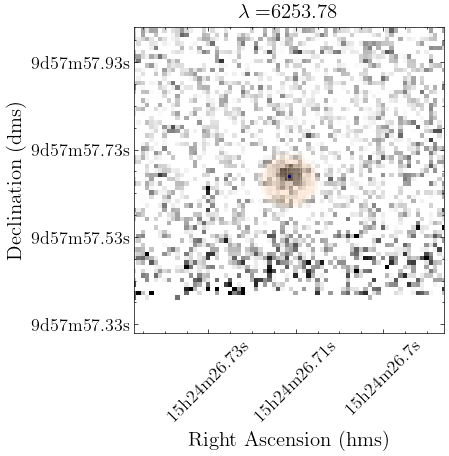

In [52]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)

Text(0, 0.5, '')

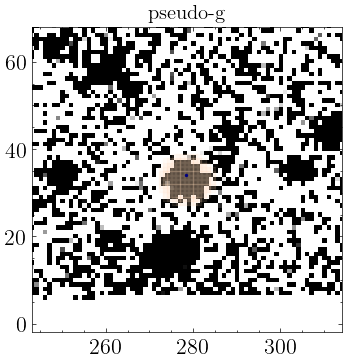

In [53]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=4800)&(wav_arr<=5800))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-g', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

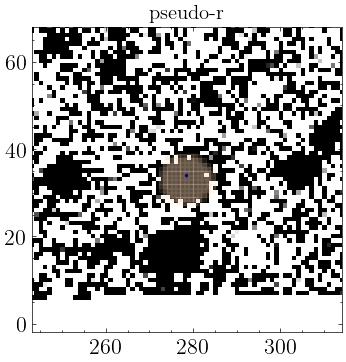

In [54]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=6000)&(wav_arr<=7500))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-r', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

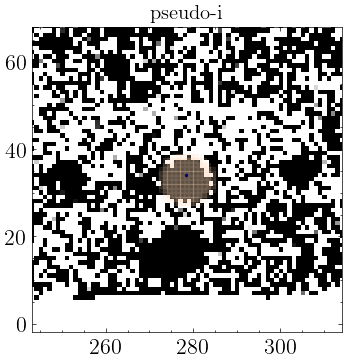

In [55]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=7500)&(wav_arr<=9000))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-i', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

In [56]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [57]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0)/len(gal_x))

In [58]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'])

(25.683, 0.006)

In [59]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'])

(24.147, 0.002)

In [60]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'])

(23.8, 0.003)

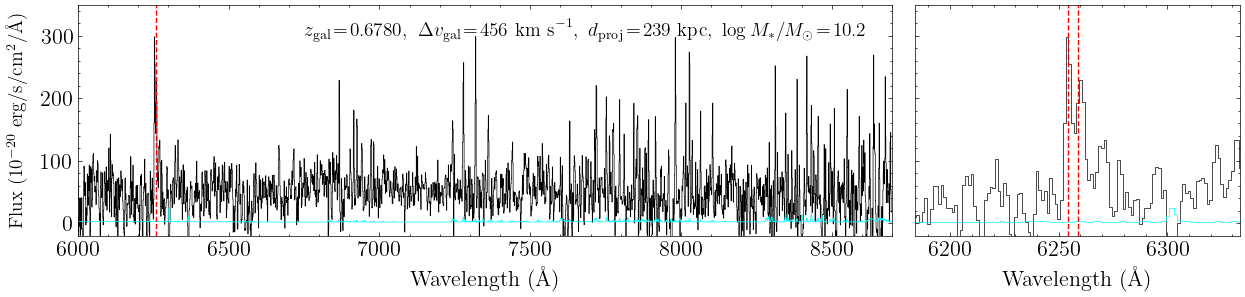

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6750, 300, 
             r'$z_\mathrm{gal}\!=\!0.6780, \ \Delta v_\mathrm{gal}\!=\!456 \ \mathrm{km \ s}^{-1}, \ d_\mathrm{proj} \!=\! 239 \ \mathrm{kpc}, \ \log M_*/M_\odot \!=\! 10.2$', 
             fontsize=14)
axes[0].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-20, 350)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3729.875*(1+z_gal)-75, 3729.875*(1+z_gal)+75)
axes[1].axvline(3727.092*(1+z_gal), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=0.67545705/z_067_gal.pdf', dpi=300)

(-20.0, 350.0)

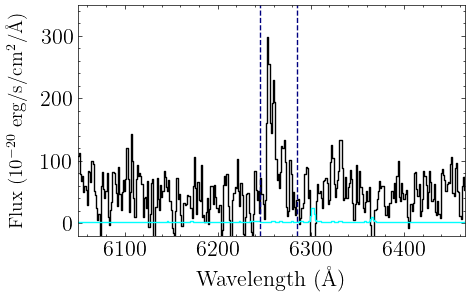

In [68]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')

#ax.axvline(3727.092*(1+z_gal), linestyle='--', color='red')
#ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

#ax.axvline(6250, linestyle='--', color='navy')
#ax.axvline(6266, linestyle='--', color='navy')

ax.axvline(6245, linestyle='--', color='navy')
ax.axvline(6285, linestyle='--', color='navy')

ax.axvspan(7600,7630, color='yellow', alpha=.2)
ax.axvspan(7880,7995, color='yellow', alpha=.2)

ax.set_xlim(6050, 6466)
ax.set_ylim(-20, 350)

In [69]:
idx = (wav_arr>=6245)&(wav_arr<=6285)

In [70]:
np.sum(spec_gal[idx][:-1])*1.25*1e-20/1e-17, np.sqrt(np.sum(err_gal[:-1]**2))*1.25*1e-20/1e-17

(3.806425779442342, 0.3011150326610853)

# z=1.09

In [71]:
z_gal = 1.0959

In [72]:
wav_plot = 3729.875*(1+z_gal)
wav_plot_idx = np.argmin(np.abs(wav_arr-wav_plot))

In [73]:
gal_ex_id = 27

In [74]:
seg_map_gal_ex_y, seg_map_gal_ex_x = np.where(seg_map==gal_ex_id)

In [75]:
gal_pix_x = np.mean(seg_map_gal_ex_x)
gal_pix_y = np.mean(seg_map_gal_ex_y)

In [76]:
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])

X,Y = np.meshgrid(x,y)

In [77]:
r_gal = 3
gal_y, gal_x = np.where((X-gal_pix_x)**2+(Y-gal_pix_y)**2<r_gal**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/2922892043.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/2922892043.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


(243.0, 308.0)

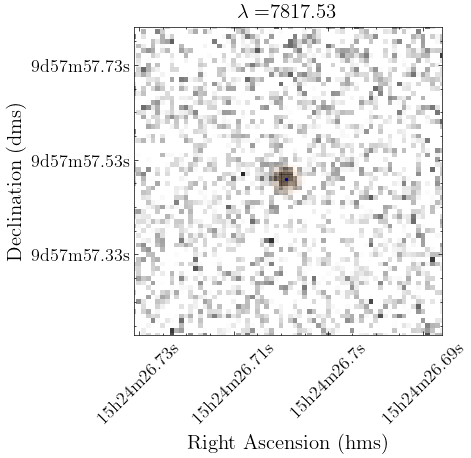

In [78]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

#ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s=20)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_1_x_pix, gal_1_y_pix, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)

Text(0, 0.5, '')

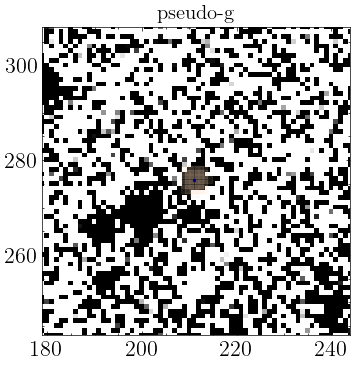

In [79]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=4800)&(wav_arr<=5800))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-g', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

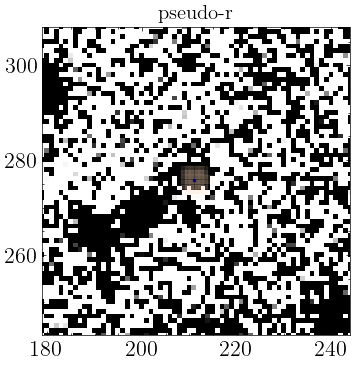

In [80]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=6000)&(wav_arr<=7500))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-r', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

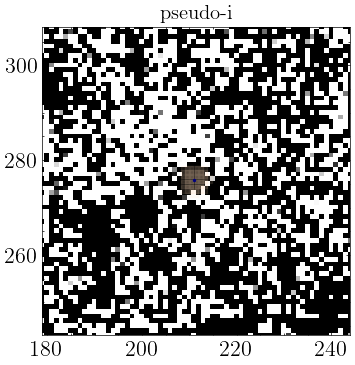

In [81]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=7500)&(wav_arr<=9000))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-i', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

In [82]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [83]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0)/len(gal_x))

In [84]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'])

(26.415, 0.011)

In [85]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'])

(26.204, 0.01)

In [86]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'])

(25.714, 0.017)

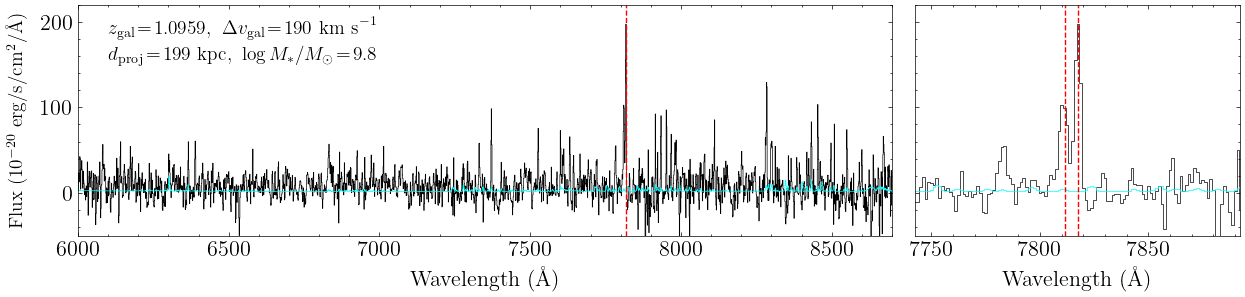

In [88]:
#fig, axes = plt.subplots(1, 2, figsize=(9,2.8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6100, 185, 
             r'$z_\mathrm{gal}\!=\!1.0959, \ \Delta v_\mathrm{gal}\!=\!190 \ \mathrm{km \ s}^{-1}$', 
             fontsize=14)
axes[0].text(6100, 155, 
             r'$d_\mathrm{proj}\!=\!199 \ \mathrm{kpc}, \ \log M_*/M_\odot \!=\!9.8$', 
             fontsize=14)
axes[0].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-50, 220)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3729.875*(1+z_gal)-75, 3729.875*(1+z_gal)+75)
axes[1].axvline(3727.092*(1+z_gal), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.09456549/z_109_gal.pdf', dpi=300)

(-50.0, 260.0)

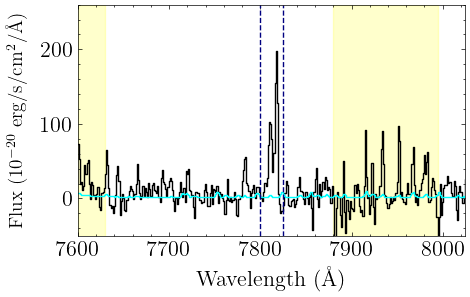

In [89]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')

#ax.axvline(3727.092*(1+z_gal), linestyle='--', color='red')
#ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(7800, linestyle='--', color='navy')
ax.axvline(7825, linestyle='--', color='navy')

ax.axvspan(7600,7630, color='yellow', alpha=.2)
ax.axvspan(7880,7995, color='yellow', alpha=.2)

ax.set_xlim(7600, 8025)
ax.set_ylim(-50, 260)

In [90]:
idx = (wav_arr>=7800)&(wav_arr<=7825)

In [91]:
np.sum(spec_gal[idx][:-1])*1.25*1e-20/1e-17, np.sqrt(np.sum(err_gal[:-1]**2))*1.25*1e-20/1e-17

(1.226856785874115, 0.2814960660851256)

# z=1.22

In [92]:
z_gal = 1.2256

In [93]:
wav_plot = 3729.875*(1+z_gal)
wav_plot_idx = np.argmin(np.abs(wav_arr-wav_plot))

In [94]:
gal_ex_id = 58

In [95]:
seg_map_gal_ex_y, seg_map_gal_ex_x = np.where(seg_map==gal_ex_id)

In [96]:
gal_pix_x = np.mean(seg_map_gal_ex_x)
gal_pix_y = np.mean(seg_map_gal_ex_y)

In [97]:
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])

X,Y = np.meshgrid(x,y)

In [98]:
r_gal = 3
gal_y, gal_x = np.where((X-gal_pix_x)**2+(Y-gal_pix_y)**2<r_gal**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/2437623747.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/2437623747.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


(154.0, 219.0)

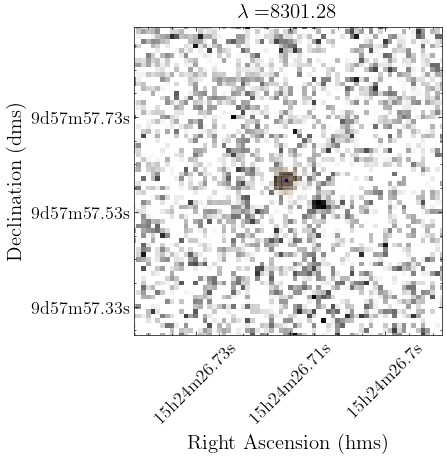

In [99]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 25, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)

Text(0, 0.5, '')

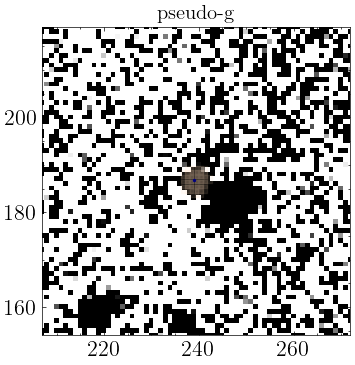

In [100]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=4800)&(wav_arr<=5800))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-g', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

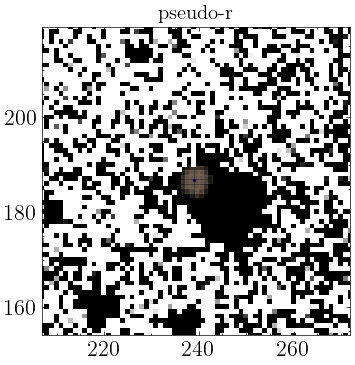

In [101]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=6000)&(wav_arr<=7500))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-r', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

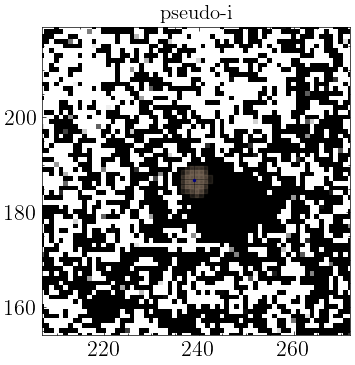

In [102]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=7500)&(wav_arr<=9000))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-i', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

In [103]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [104]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0)/len(gal_x))

In [105]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'])

(25.945, 0.008)

In [106]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'])

(25.405, 0.005)

In [107]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'])

(24.852, 0.008)

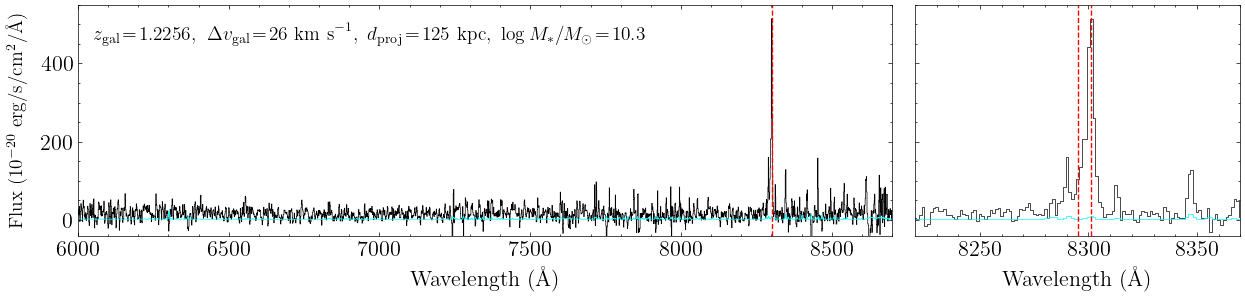

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6050, 460, 
             r'$z_\mathrm{gal}\!=\!1.2256, \ \Delta v_\mathrm{gal}\!=\! 26 \ \mathrm{km \ s}^{-1}, \ d_\mathrm{proj}\!=\!125 \ \mathrm{kpc}, \ \log M_*/M_\odot \!=\!10.3$', 
             fontsize=14)
axes[0].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-40, 550)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3727.092*(1+z_gal)-75, 3727.092*(1+z_gal)+75)
axes[1].axvline(3727.092*(1+z_gal), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.22541394/z_122_gal.pdf', dpi=300)

(-40.0, 550.0)

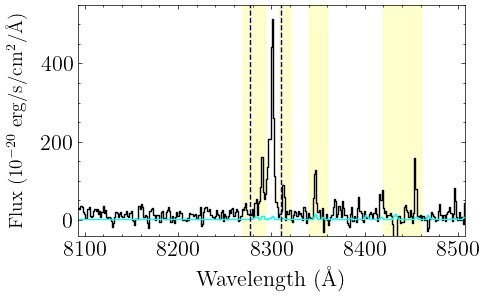

In [111]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')

#ax.axvline(3727.092*(1+z_gal), linestyle='--', color='red')
#ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

#ax.axvline(8293, linestyle='--', color='navy')
#ax.axvline(8308, linestyle='--', color='navy')

ax.axvline(8277, linestyle='--', color='navy')
ax.axvline(8310, linestyle='--', color='navy')

ax.axvspan(8270,8293, color='yellow', alpha=.2)
ax.axvspan(8308,8320, color='yellow', alpha=.2)
ax.axvspan(8340,8360, color='yellow', alpha=.2)
ax.axvspan(8420,8460, color='yellow', alpha=.2)

ax.set_xlim(8293-200, 8308+200)
ax.set_ylim(-40, 550)

In [112]:
idx = (wav_arr>=8277)&(wav_arr<=8310)

In [113]:
np.sum(spec_gal[idx][:-1])*1.25*1e-20/1e-17, np.sqrt(np.sum(err_gal[:-1]**2))*1.25*1e-20/1e-17

(3.4630961763905357, 0.29037650533218956)

# z=1.27

In [114]:
z_gal = 1.2787

In [115]:
wav_plot = 3729.875*(1+z_gal)
wav_plot_idx = np.argmin(np.abs(wav_arr-wav_plot))

In [116]:
gal_ex_id = 87

In [117]:
seg_map_gal_ex_y, seg_map_gal_ex_x = np.where(seg_map==gal_ex_id)

In [118]:
gal_pix_x = np.mean(seg_map_gal_ex_x)
gal_pix_y = np.mean(seg_map_gal_ex_y)

In [119]:
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])

X,Y = np.meshgrid(x,y)

In [120]:
r_gal = 3
gal_y, gal_x = np.where((X-gal_pix_x)**2+(Y-gal_pix_y)**2<r_gal**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/1878457216.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/1878457216.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


(53.0, 118.0)

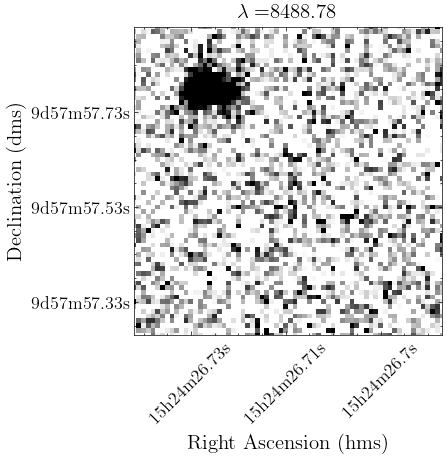

In [121]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx-8,:,:], vmin = 0, vmax = 5, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

#ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
#ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx-8], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/622882812.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/622882812.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


(53.0, 118.0)

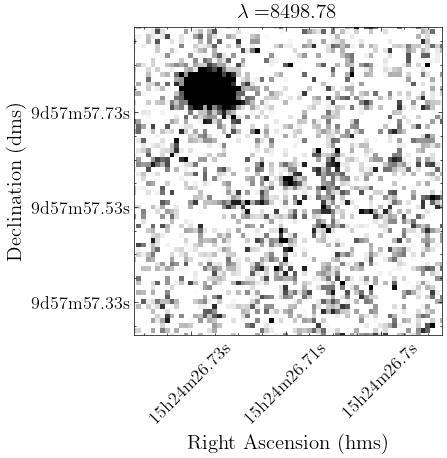

In [122]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 5, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

#ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
#ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/1410175006.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_26819/1410175006.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


(53.0, 118.0)

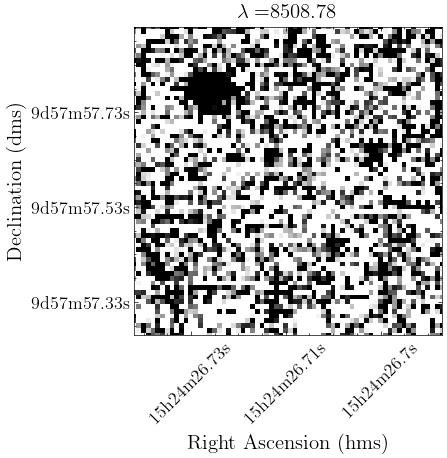

In [123]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx+8,:,:], vmin = 0, vmax = 5, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

#ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
#ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx+8], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)

In [124]:
circ_x = np.array([gal_pix_x+3*np.cos(p) for p in np.arange(0.,2*np.pi+.1, .05)])
circ_y = np.array([gal_pix_y+3*np.sin(p) for p in np.arange(0.,2*np.pi+.1, .05)])

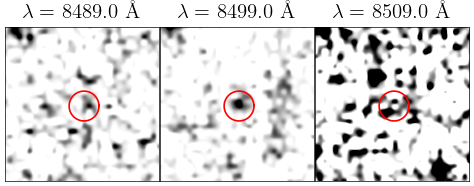

In [125]:
fig, axes = plt.subplots(1,3, figsize=(2*3,2), sharex=True, sharey=True)

axes[0].imshow(spec_cube[wav_plot_idx-8,:,:], vmin = 0, vmax = 5, cmap='Greys', interpolation='gaussian')

axes[0].set_title(r'$\lambda = $ ' + str(np.round(wav_arr[wav_plot_idx-8]))+' Å', fontsize=15)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].plot(circ_x, circ_y, lw=1.2, color='red')


axes[0].invert_yaxis()

axes[0].set_xlim(np.min(gal_x)-13, np.max(gal_x)+13)
axes[0].set_ylim(np.min(gal_y)-13, np.max(gal_y)+13)

axes[1].imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 5, cmap='Greys', interpolation='gaussian')
axes[1].plot(circ_x, circ_y, lw=1.2, color='red')

axes[1].set_title(r'$\lambda = $ ' + str(np.round(wav_arr[wav_plot_idx]))+' Å', fontsize=15)

axes[1].invert_yaxis()

axes[1].set_xlim(np.min(gal_x)-13, np.max(gal_x)+13)
axes[1].set_ylim(np.min(gal_y)-13, np.max(gal_y)+13)

axes[2].imshow(spec_cube[wav_plot_idx+8,:,:], vmin = 0, vmax = 5, cmap='Greys', interpolation='gaussian')
axes[2].plot(circ_x, circ_y, lw=1.2, color='red')

axes[2].set_title(r'$\lambda = $ ' + str(np.round(wav_arr[wav_plot_idx+8]))+' Å', fontsize=15)
axes[2].invert_yaxis()

axes[2].set_xlim(np.min(gal_x)-13, np.max(gal_x)+13)
axes[2].set_ylim(np.min(gal_y)-13, np.max(gal_y)+13)

plt.subplots_adjust(wspace=0., hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal_img.pdf', dpi=300)

Text(0, 0.5, '')

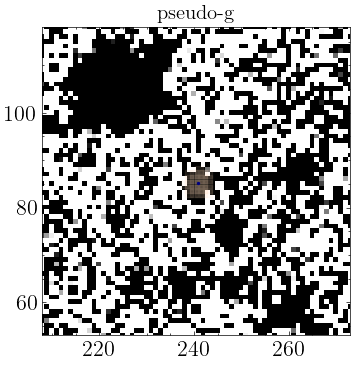

In [126]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=4800)&(wav_arr<=5800))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-g', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

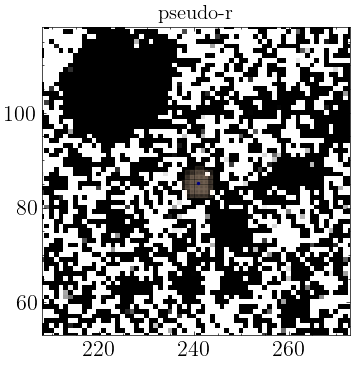

In [127]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=6000)&(wav_arr<=7500))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-r', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

Text(0, 0.5, '')

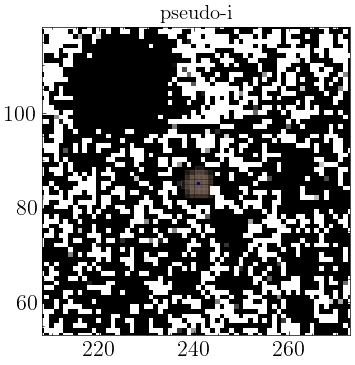

In [128]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(np.nansum(spec_cube[np.where((wav_arr>=7500)&(wav_arr<=9000))[0],:,:], axis=0), vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(gal_x, gal_y, color='peachpuff', marker='s',alpha=.1)
ax.scatter(gal_pix_x, gal_pix_y, color='navy', s=2)

#ax.scatter(gal_pix_x, gal_pix_y, color='red', s= 20)

ax.set_title(r'pseudo-i', fontsize=15)
#ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
#ax.set_yticklabels(Dec_arr_labels, fontsize=13)

#ax.set_xlabel('Right Ascension (hms)', fontsize=15)
#ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()
ax.set_xlim(np.min(gal_x)-30, np.max(gal_x)+30)
ax.set_ylim(np.min(gal_y)-30, np.max(gal_y)+30)
ax.set_xlabel(None)
ax.set_ylabel(None)

In [129]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [130]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0)/len(gal_x))

In [131]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'])

(26.446, 0.012)

In [132]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'])

(25.299, 0.005)

In [133]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'])

(24.26, 0.005)

In [134]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [135]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

In [136]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [137]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [138]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

In [139]:
z_arr = np.arange(-0.1,1.4,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [140]:
model_params = np.zeros((len(z_arr), 4))

In [141]:
idx = ~np.isnan(spec_gal)

In [142]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][20:-20])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            spec_gal[idx][20:-20], err_gal[idx][20:-20])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        spec_gal[idx][20:-20], err_gal[idx][20:-20], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

In [143]:
z = z_arr[np.argmin(red_chi_sq_arr)]
c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr)

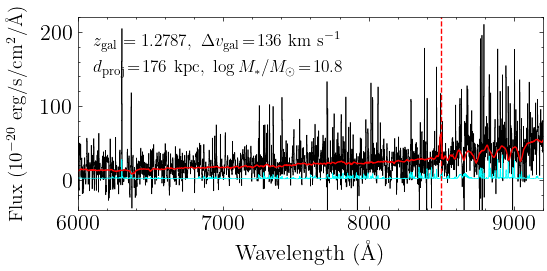

In [146]:
fig, ax = plt.subplots(1,figsize=(6,2.5))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.text(6100, 180, 
             r'$z_\mathrm{gal}=1.2787, \ \Delta v_\mathrm{gal}\!=\!136 \ \mathrm{km \ s}^{-1}$', 
             fontsize=12.5)
ax.text(6100, 145, 
             r'$d_\mathrm{proj}\!=\!176 \ \mathrm{kpc}, \ \log M_*/M_\odot \!=\!10.8$', 
             fontsize=12.5)
ax.plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1, color='red')
ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlim(6000, 9200)
ax.set_ylim(-40, 220)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal.pdf', dpi=300)

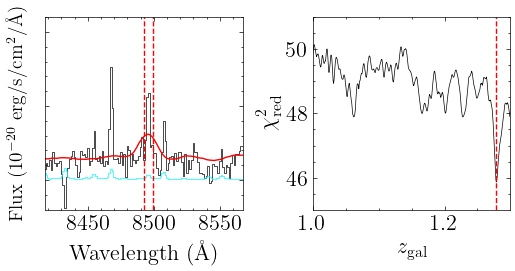

In [145]:
fig, axes = plt.subplots(1,2,figsize=(6,2.5))

axes[0].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)
axes[0].plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1, color='red')

axes[0].set_xlim(3727.092*(1+z_gal)-75, 3727.092*(1+z_gal)+75)
axes[0].set_ylim(-40, 220)
axes[0].axvline(3727.092*(1+z_gal), linestyle='--', color='red')
axes[0].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

#axes[1].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[0].set_ylabel('')
axes[0].set_yticklabels([])

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].plot(z_arr, red_chi_sq_arr, lw=.5)
axes[1].axvline(z_arr[np.argmin(red_chi_sq_arr)],color='red', linestyle='--')

axes[1].set_xlabel(r'$z_\mathrm{gal}$')
axes[1].set_ylabel(r'$\chi^2_\mathrm{red}$')

axes[1].set_xlim(1.0,1.3)
axes[1].set_ylim(45,51)

plt.subplots_adjust(wspace=0.35, hspace=0.5)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal_fit.pdf', dpi=300)

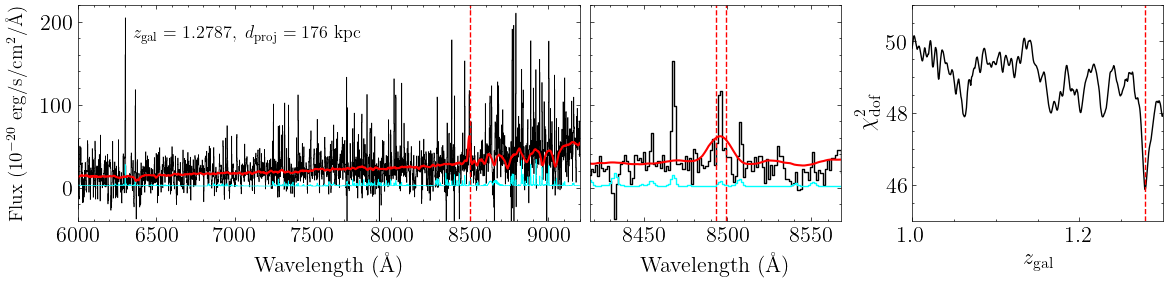

In [150]:
fig, axes = plt.subplots(1, 4, figsize=(14,2.8), gridspec_kw={'width_ratios': [2, 1, .2, 1]})

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6350, 180, 
             r'$z_\mathrm{gal}=1.2787, \ d_\mathrm{proj} = 176 \ \mathrm{kpc}$', 
             fontsize=13)
axes[0].plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1.5, color='red')
axes[0].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

axes[0].set_xlim(6000, 9200)
axes[0].set_ylim(-40, 220)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_arr, 
              spec_gal, where='mid')
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan')
axes[1].plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1.5, color='red')

axes[1].set_xlim(3727.092*(1+z_gal)-75, 3727.092*(1+z_gal)+75)
axes[1].set_ylim(-40, 220)
axes[1].axvline(3727.092*(1+z_gal), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+z_gal), linestyle='--', color='red')

#axes[1].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[1].set_ylabel('')
axes[1].set_yticklabels([])

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

axes[2].set_visible(False)
axes[3].plot(z_arr, red_chi_sq_arr)
axes[3].axvline(z_arr[np.argmin(red_chi_sq_arr)],color='red', linestyle='--')

axes[3].set_xlabel(r'$z_\mathrm{gal}$')
axes[3].set_ylabel(r'$\chi^2_\mathrm{dof}$')

axes[3].set_xlim(1.0,1.3)
axes[3].set_ylim(45,51)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal.pdf', dpi=300)

(45.0, 51.0)

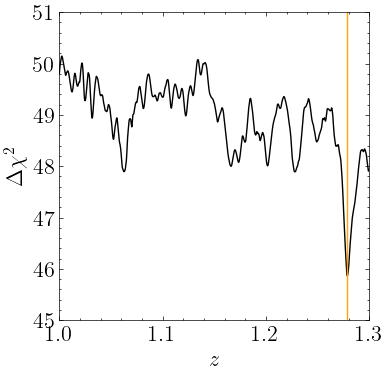

In [151]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(z_arr, red_chi_sq_arr)
ax.axvline(z_arr[np.argmin(red_chi_sq_arr)],color='orange')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\Delta \chi^2$')

ax.set_xlim(1.0,1.3)
ax.set_ylim(45,51)

(-10.0, 180.0)

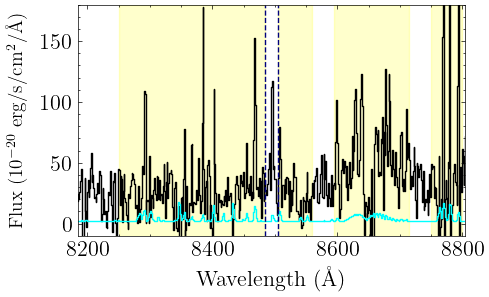

In [152]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(8485, linestyle='--', color='navy')
ax.axvline(8505, linestyle='--', color='navy')

ax.axvspan(8250,8485, color='yellow', alpha=.2)
ax.axvspan(8505,8560, color='yellow', alpha=.2)
ax.axvspan(8595,8715, color='yellow', alpha=.2)
ax.axvspan(8750,8800, color='yellow', alpha=.2)

ax.set_xlim(8485-300, 8505+300)
ax.set_ylim(-10, 180)

In [153]:
idx = (wav_arr>=8485)&(wav_arr<=8505)

In [154]:
np.sum(spec_gal[idx][:-1])*1.25*1e-20/1e-17, np.sqrt(np.sum(err_gal[:-1]**2))*1.25*1e-20/1e-17

(0.8830331089187529, 0.31640937094034416)

# DRAFT

Plot $\chi^2$ versus $z$

In [8]:
gal_id = 58

In [9]:
gal_model_arr = np.loadtxt(rootdir+'gal{}/gal{}_model.dat'.format(gal_id, gal_id), delimiter='\t')

In [10]:
z_arr = gal_model_arr[:,0]
chi_sq_arr = gal_model_arr[:,5]

In [11]:
z_best = z_arr[np.argmin(chi_sq_arr)]

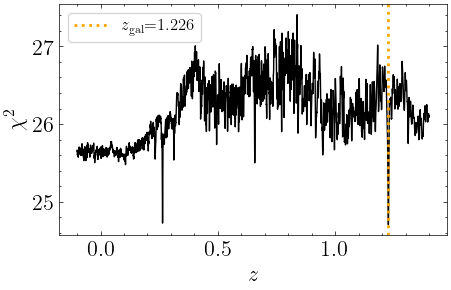

In [12]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.plot(z_arr, chi_sq_arr)
ax.axvline(z_best, color='orange', linestyle=':', lw=2, label=r'$z_{\mathrm{gal}}$' +'={}'.format(np.round(z_best, 3)))

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\chi^2$')
#ax.set_title('Galaxy {}'.format(gal_id))

ax.legend()

Plot galaxy spectrum with atomic lines

In [13]:
gal_id = 58

In [14]:
idx = np.where(gal_ids_arr==gal_id)[0][0]

In [15]:
z_best = z_ids_arr[idx]

In [16]:
z_best

1.2256

In [17]:
gal_spec_arr = np.loadtxt(rootdir+'gal{}/gal{}_spec.dat'.format(gal_id, gal_id), delimiter='\t')

In [18]:
wav_arr = gal_spec_arr[:,0]
gal_spec_raw = gal_spec_arr[:,1]
gal_spec_err = gal_spec_arr[:,2]
gal_spec_fit = gal_spec_arr[:,3]

In [19]:
d_proj = 126

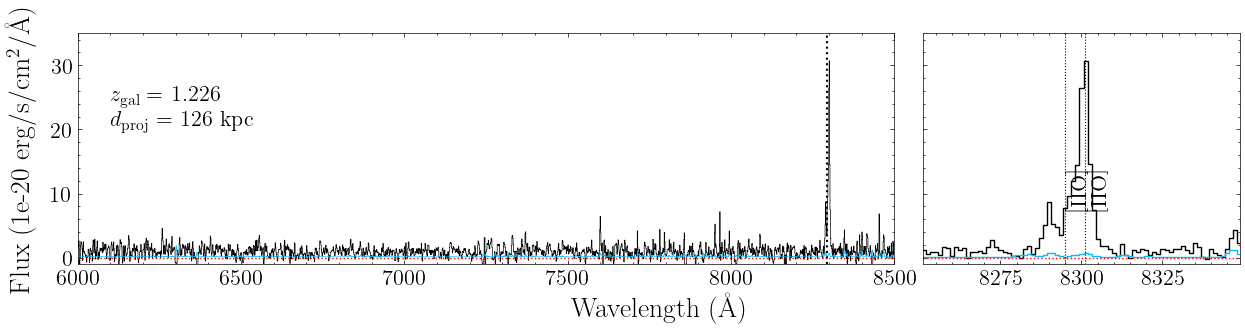

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), squeeze=True, sharey=True,
                       gridspec_kw = {'width_ratios':[1.8,0.7]})

axes[0].step(wav_arr, gal_spec_raw, where='mid', lw=0.5)
axes[0].step(wav_arr, gal_spec_err, where='mid', lw=0.5)
axes[0].axhline(0, linestyle=':', color='red')

axes[0].axvline(3727.09*(1+z_best), linestyle=':', lw=1.5)


axes[0].text(x=6100, y=24.5, s=r'$z_{\mathrm{gal}}=$'+' {:.3f}'.format(z_best))
axes[0].text(x=6100, y=20.5, s=r'$d_{\mathrm{proj}}=$'+' {} kpc'.format(d_proj))

axes[0].set_xlim(6000,8500)
axes[0].set_ylim(-1, 35)

axes[1].step(wav_arr, gal_spec_raw, where='mid')
axes[1].step(wav_arr, gal_spec_err, where='mid')
axes[1].axhline(0, linestyle=':', color='red')

plot_gal_lines(axes[1], z_best, plot_list=['[OII]'], 
               y_pos=7.5, lw=0.8, wav_min = 8200, wav_max=8500)

axes[1].set_xlim(8251,8349)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'Wavelength (Å)', labelpad=20, fontsize=20)
ax_label.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)',  labelpad=30, fontsize=20)

plt.subplots_adjust(wspace=0.05)


#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_gal_spec.pdf'.format(str(z_abs), 
#                                                                                                         str(z_abs).replace('.', '_')), 
#            dpi=300)

In [23]:
1472.5*1e+3*33.8*4.84814e-6

241.29435186999996

In [24]:
np.round(3e+5*(z_abs-z_best)/(1+z_best))

NameError: name 'z_abs' is not defined

Plot galaxy spectrum with atomic lines

In [22]:
gal_id = 105

In [23]:
idx = np.where(gal_ids_arr==gal_id)[0][0]

In [24]:
z_best = z_ids_arr[idx]

In [25]:
z_best

0.678

In [26]:
gal_spec_arr = np.loadtxt(rootdir+'gal{}/gal{}_spec.dat'.format(gal_id, gal_id), delimiter='\t')

In [27]:
wav_arr = gal_spec_arr[:,0]
gal_spec_raw = gal_spec_arr[:,1]
gal_spec_err = gal_spec_arr[:,2]
gal_spec_fit = gal_spec_arr[:,3]

In [32]:
z_abs = 0.67530885

In [33]:
d_proj = 241

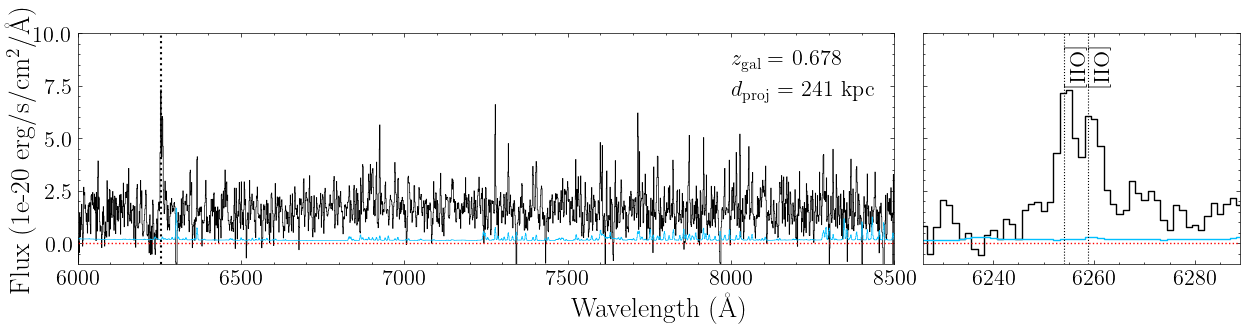

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), squeeze=True, sharey=True,
                       gridspec_kw = {'width_ratios':[1.8,0.7]})

axes[0].step(wav_arr, gal_spec_raw, where='mid', lw=0.5)
axes[0].step(wav_arr, gal_spec_err, where='mid', lw=0.5)
axes[0].axhline(0, linestyle=':', color='red')

axes[0].axvline(3727.09*(1+z_best), linestyle=':', lw=1.5)


axes[0].text(x=8000, y=8.5, s=r'$z_{\mathrm{gal}}=$'+' {:.3f}'.format(z_best))
axes[0].text(x=8000, y=7, s=r'$d_{\mathrm{proj}}=$'+' {} kpc'.format(d_proj))

axes[0].set_xlim(6000,8500)
axes[0].set_ylim(-1, 10)

axes[1].step(wav_arr, gal_spec_raw, where='mid')
axes[1].step(wav_arr, gal_spec_err, where='mid')
axes[1].axhline(0, linestyle=':', color='red')

plot_gal_lines(axes[1], z_best, plot_list=['[OII]'], 
               y_pos=7.5, lw=0.8, wav_min = 6100, wav_max=7000)

axes[1].set_xlim(6226,6289)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'Wavelength (Å)', labelpad=20, fontsize=20)
ax_label.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)',  labelpad=30, fontsize=20)

plt.subplots_adjust(wspace=0.05)


plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_gal_spec.pdf'.format(str(z_abs), 
                                                                                                         str(z_abs).replace('.', '_')), 
            dpi=300)

In [35]:
1472.5*1e+3*33.8*4.84814e-6

241.29435186999996

In [36]:
np.round(3e+5*(z_abs-z_best)/(1+z_best))

-481.0

Next system

In [37]:
gal_id = 61

In [38]:
idx = np.where(gal_ids_arr==gal_id)[0][0]

In [39]:
z_best = z_ids_arr[idx]

In [40]:
gal_spec_arr = np.loadtxt(rootdir+'gal{}/gal{}_spec.dat'.format(gal_id, gal_id), delimiter='\t')

In [41]:
wav_arr = gal_spec_arr[:,0]
gal_spec_raw = gal_spec_arr[:,1]
gal_spec_err = gal_spec_arr[:,2]
gal_spec_fit = gal_spec_arr[:,3]

In [42]:
z_abs = 0.72882547

In [43]:
d_proj = 179

(-2.5, 35.0)

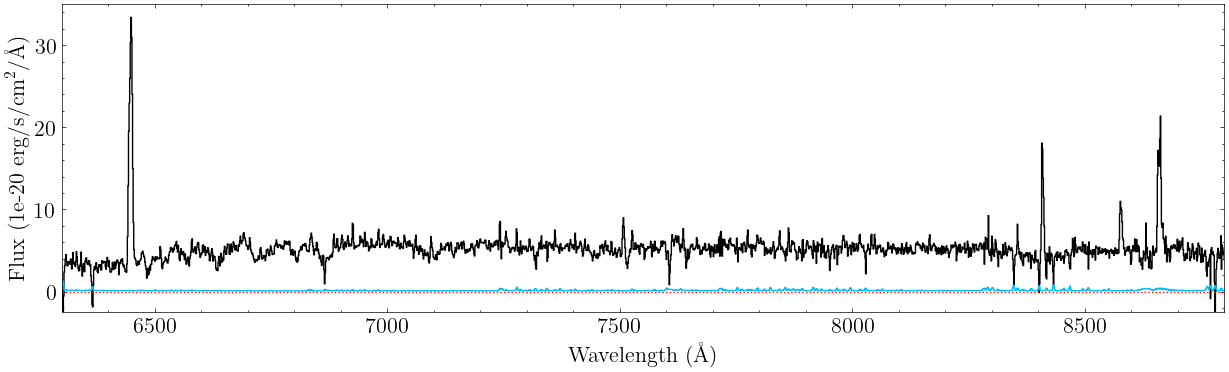

In [44]:
fig, ax = plt.subplots(1, figsize=(15,4))

ax.step(wav_arr, gal_spec_raw, where='mid')
ax.step(wav_arr, gal_spec_err, where='mid')
ax.axhline(0, linestyle=':', color='red')

#plot_gal_lines(ax, z_best, plot_list=['[OII]', 'CaIIH', 'CaIIK', 
#                                      'Hb', 'Hd', 'Hg', '[OIII]', 'G-band'], 
#               y_pos=15, wav_min=6000, wav_max=9000, lw=0.8)

ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)')

#ax.text(x=8400, y=28, s=r'$z=$'+' {:.3f}'.format(z_best))
#ax.text(x=8400, y=25, s=r'$d_{\mathrm{proj}}=$'+' {} kpc'.format(d_proj))

ax.set_xlim(6300,8800)
ax.set_ylim(-2.5, 35)

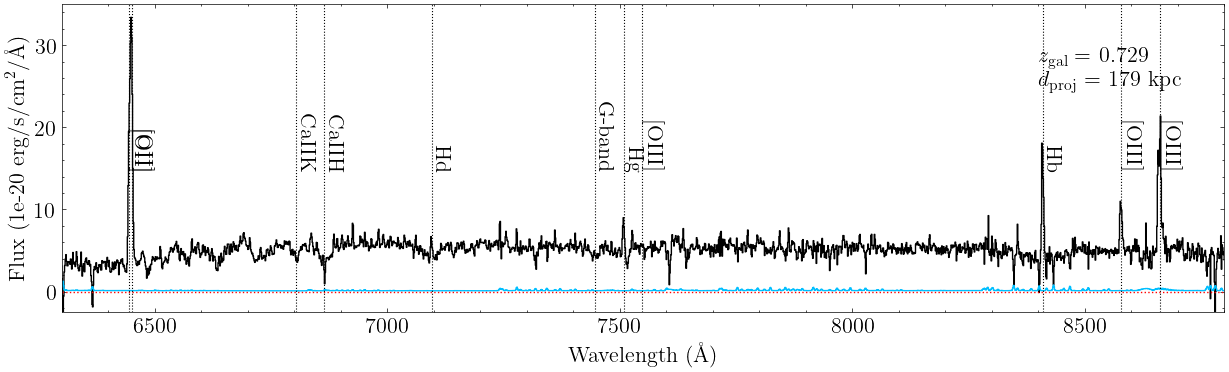

In [45]:
fig, ax = plt.subplots(1, figsize=(15,4))

ax.step(wav_arr, gal_spec_raw, where='mid')
ax.step(wav_arr, gal_spec_err, where='mid')
ax.axhline(0, linestyle=':', color='red')

plot_gal_lines(ax, z_best, plot_list=['[OII]', 'CaIIH', 'CaIIK', 
                                      'Hb', 'Hd', 'Hg', '[OIII]', 'G-band'], 
               y_pos=15, wav_min=6000, wav_max=9000, lw=0.8)

ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)')

ax.text(x=8400, y=28, s=r'$z_{\mathrm{gal}}=$'+' {:.3f}'.format(z_best))
ax.text(x=8400, y=25, s=r'$d_{\mathrm{proj}}=$'+' {} kpc'.format(d_proj))
ax.set_ylim(-2.5, 35)

ax.set_xlim(6300,8800)
ax.set_ylim(-2.5, 35)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_gal_spec.pdf'.format(str(z_abs), 
                                                                                                         str(z_abs).replace('.', '_')), 
            dpi=300)

In [46]:
1516.1*1e+3*24.3*4.84814e-6

178.6114408122

In [47]:
3e+5*(z_abs-z_best)/(1+z_best)

-82.32174868443411

Next system

In [48]:
gal_id = 27

In [49]:
idx = np.where(gal_ids_arr==gal_id)[0][0]

In [50]:
z_best = z_ids_arr[idx]

In [51]:
gal_spec_arr = np.loadtxt(rootdir+'gal{}/gal{}_spec.dat'.format(gal_id, gal_id), delimiter='\t')

In [52]:
wav_arr = gal_spec_arr[:,0]
gal_spec_raw = gal_spec_arr[:,1]
gal_spec_err = gal_spec_arr[:,2]
gal_spec_fit = gal_spec_arr[:,3]

In [53]:
z_abs = 1.09456549

In [54]:
d_proj = 202

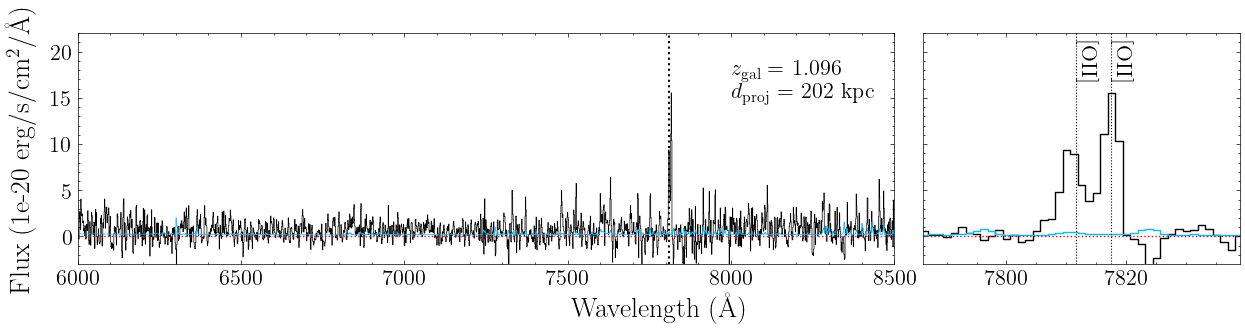

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), squeeze=True, sharey=True,
                       gridspec_kw = {'width_ratios':[1.8,0.7]})

axes[0].step(wav_arr, gal_spec_raw, where='mid', lw=0.5)
axes[0].step(wav_arr, gal_spec_err, where='mid', lw=0.5)
axes[0].axhline(0, linestyle=':', color='red')

axes[0].axvline(3727.09*(1+z_best), linestyle=':', lw=1.5)


axes[0].text(x=8000, y=17.5, s=r'$z_{\mathrm{gal}}=$'+' {:.3f}'.format(z_best))
axes[0].text(x=8000, y=15, s=r'$d_{\mathrm{proj}}=$'+' {} kpc'.format(d_proj))

axes[0].set_xlim(6000,8500)
axes[0].set_ylim(-3, 22)

axes[1].step(wav_arr, gal_spec_raw, where='mid')
axes[1].step(wav_arr, gal_spec_err, where='mid')
axes[1].axhline(0, linestyle=':', color='red')

plot_gal_lines(axes[1], z_best, plot_list=['[OII]'], 
               y_pos=17, lw=0.8, wav_min = 7500, wav_max=8000)

axes[1].set_xlim(7786,7839)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'Wavelength (Å)', labelpad=20, fontsize=20)
ax_label.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)',  labelpad=30, fontsize=20)

plt.subplots_adjust(wspace=0.05)


plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_gal_spec.pdf'.format(str(z_abs), 
                                                                                                         str(z_abs).replace('.', '_')), 
            dpi=300)

(-5.5, 27.0)

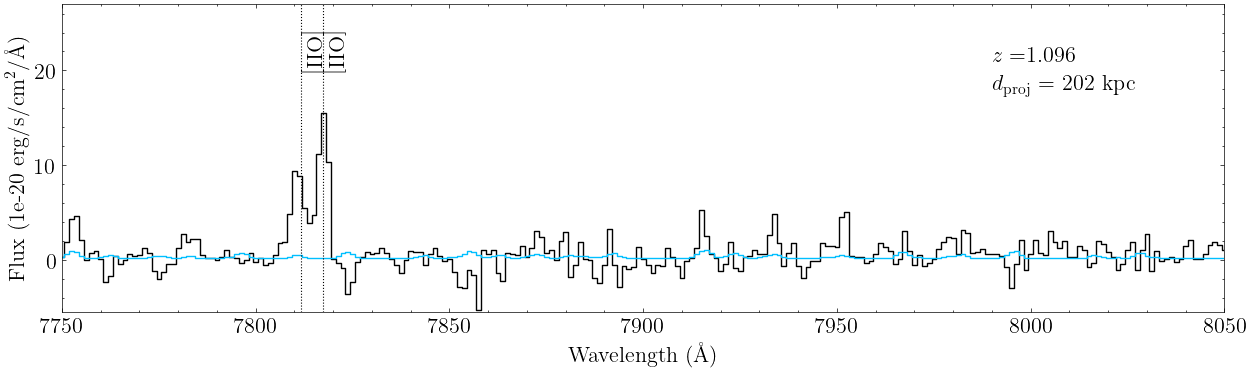

In [61]:
fig, ax = plt.subplots(1, figsize=(15,4))

ax.step(wav_arr, gal_spec_raw, where='mid')
ax.step(wav_arr, gal_spec_err, where='mid')

plot_gal_lines(ax, z_best, plot_list=['[OII]'], y_pos=20, lw=0.8,
              wav_min=7770, wav_max=9300)


ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)')

ax.text(x=7990, y=21, s=r'$z=$'+'{:.3f}'.format(z_best))
ax.text(x=7990, y=18, s=r'$d_{\mathrm{proj}}=$'+' {} kpc'.format(d_proj))

ax.set_ylim(-5.5, 32)

ax.set_xlim(7750,8050)
ax.set_ylim(-5.5, 27)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_gal_spec.pdf'.format(str(z_abs), 
#                                                                                                         str(z_abs).replace('.', '_')), 
#            dpi=300)

In [62]:
1709.4*1e+3*24.4*4.84814e-6

202.2128165904

In [63]:
3e+5*(z_abs-z_best)/(1+z_best)

-191.01722410422883

Next system

In [8]:
gal_id = 87

In [9]:
idx = np.where(gal_ids_arr==gal_id)[0][0]

In [10]:
z_best = z_ids_arr[idx]

In [11]:
gal_spec_arr = np.loadtxt(rootdir+'gal{}/gal{}_spec.dat'.format(gal_id, gal_id), delimiter='\t')

In [12]:
wav_arr = gal_spec_arr[:,0]
gal_spec_raw = gal_spec_arr[:,1]
gal_spec_err = gal_spec_arr[:,2]
gal_spec_fit = gal_spec_arr[:,3]

In [13]:
z_abs = 1.27767328

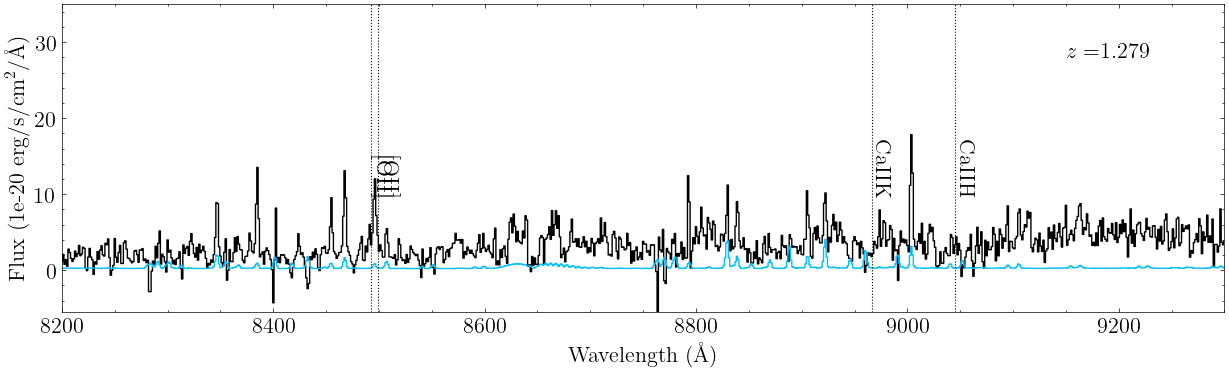

In [20]:
fig, ax = plt.subplots(1, figsize=(15,4))

ax.step(wav_arr, gal_spec_raw, where='mid')
ax.step(wav_arr, gal_spec_err, where='mid')

plot_gal_lines(ax, z_best, plot_list=['[OII]', 'CaIIH', 'CaIIK'], 
               y_pos=10, wav_min=8400, wav_max=9400, lw=0.8)

ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)')

ax.text(x=9150, y=28, s=r'$z=$'+'{:.3f}'.format(z_best))
ax.set_ylim(-5.5, 32)

ax.set_xlim(8200,9300)
ax.set_ylim(-5.5, 35)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_gal_spec.pdf'.format(str(z_abs), 
                                                                                                         str(z_abs).replace('.', '_')), 
            dpi=300)

In [64]:
3e+5*(z_abs-z_best)/(1+z_best)

-135.1718084873002

Plot stack of galaxy spectra

Text(0, 0.5, 'Flux (1e-20 erg/s/cm${}^2$/Å)')

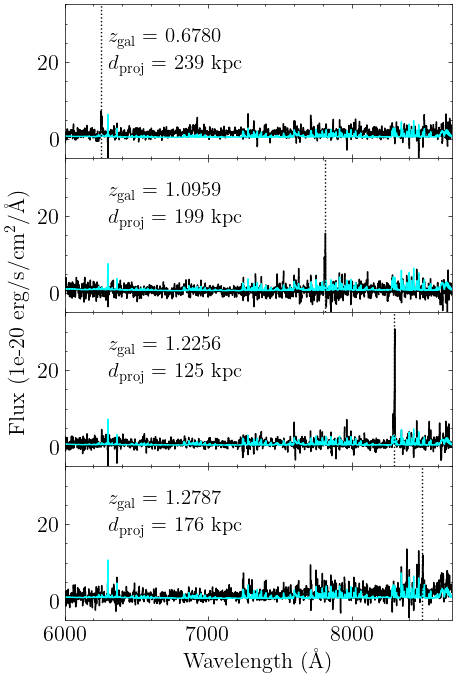

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(5,2*4), sharex=True, sharey=True)

axes[0].step(wav_grid[0], gal_spec_raw_grid[0], where='mid')
axes[0].step(wav_grid[0], gal_spec_err_grid[0], where='mid', color='cyan')
axes[0].axvline(3727.09*(1+z_best_list[0]), linestyle=':')
axes[0].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[0]), fontsize=15)
axes[0].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[0]), fontsize=15)
axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-5, 35)

axes[1].step(wav_grid[1], gal_spec_raw_grid[1], where='mid')
axes[1].step(wav_grid[1], gal_spec_err_grid[1], where='mid', color='cyan')
axes[1].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[1]), fontsize=15)
axes[1].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[1]), fontsize=15)
axes[1].axvline(3727.09*(1+z_best_list[1]), linestyle=':')

axes[2].step(wav_grid[2], gal_spec_raw_grid[2], where='mid')
axes[2].step(wav_grid[2], gal_spec_err_grid[2], where='mid', color='cyan')
axes[2].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[2]), fontsize=15)
axes[2].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[2]), fontsize=15)
axes[2].axvline(3727.09*(1+z_best_list[2]), linestyle=':')

axes[3].step(wav_grid[3], gal_spec_raw_grid[3], where='mid')
axes[3].step(wav_grid[3], gal_spec_err_grid[3], where='mid', color='cyan')
axes[3].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[3]), fontsize=15)
axes[3].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[3]), fontsize=15)
axes[3].axvline(3727.09*(1+z_best_list[3]), linestyle=':')

plt.subplots_adjust(wspace=0, hspace=0)

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel('Wavelength (Å)', labelpad=20) # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)',  labelpad=25)

#plt.savefig(rootdir+'gal_spec_stack.pdf', dpi=300)

Text(0, 0.5, 'Flux (1e-20 erg/s/cm${}^2$/Å)')

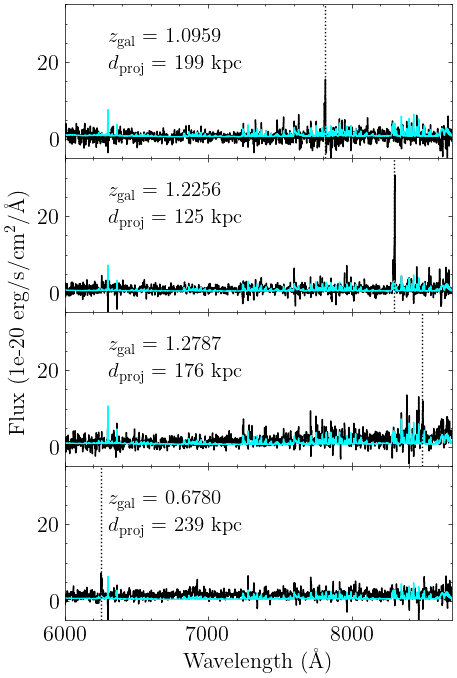

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(5,2*4), sharex=True, sharey=True)

axes[3].step(wav_grid[0], gal_spec_raw_grid[0], where='mid')
axes[3].step(wav_grid[0], gal_spec_err_grid[0], where='mid', color='cyan')
axes[3].axvline(3727.09*(1+z_best_list[0]), linestyle=':')
axes[3].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[0]), fontsize=15)
axes[3].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[0]), fontsize=15)
axes[3].set_xlim(6000, 8700)
axes[3].set_ylim(-5, 35)

axes[0].step(wav_grid[1], gal_spec_raw_grid[1], where='mid')
axes[0].step(wav_grid[1], gal_spec_err_grid[1], where='mid', color='cyan')
axes[0].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[1]), fontsize=15)
axes[0].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[1]), fontsize=15)
axes[0].axvline(3727.09*(1+z_best_list[1]), linestyle=':')

axes[1].step(wav_grid[2], gal_spec_raw_grid[2], where='mid')
axes[1].step(wav_grid[2], gal_spec_err_grid[2], where='mid', color='cyan')
axes[1].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[2]), fontsize=15)
axes[1].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[2]), fontsize=15)
axes[1].axvline(3727.09*(1+z_best_list[2]), linestyle=':')

axes[2].step(wav_grid[3], gal_spec_raw_grid[3], where='mid')
axes[2].step(wav_grid[3], gal_spec_err_grid[3], where='mid', color='cyan')
axes[2].text(6300, 25, r'$z_\mathrm{gal} = $' + ' {:.4f}'.format(z_best_list[3]), fontsize=15)
axes[2].text(6300, 18, r'$d_\mathrm{proj} = $' + ' {} kpc'.format(d_proj_list[3]), fontsize=15)
axes[2].axvline(3727.09*(1+z_best_list[3]), linestyle=':')

plt.subplots_adjust(wspace=0, hspace=0)

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel('Wavelength (Å)', labelpad=20) # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)',  labelpad=25)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/gal_spec_stack.png', dpi=300)

In [66]:
3729*(2.0959)

7815.611099999999

Load in the segmentation map for galaxy IDs

In [4]:
cat_file = np.loadtxt(rootdir + 'test_new_updated.cat')

In [5]:
gal_ids_arr = np.int_(cat_file[:,0])

In [6]:
z_ids_arr = cat_file[:,12]

# Gather data

In [7]:
gal_ids_list = [105, 27, 58, 87]

z_best_list = []
wav_grid = []
v_grid = []
gal_spec_raw_grid = []
gal_spec_err_grid = []
gal_spec_fit_grid = []

for gal_id in gal_ids_list:
    
    idx = np.where(gal_ids_arr==gal_id)[0][0]

    z_best_list.append(z_ids_arr[idx])
    
    gal_spec_arr = np.loadtxt(rootdir+'gal{}/gal{}_spec.dat'.format(gal_id, gal_id), delimiter='\t')

    wav_grid.append(gal_spec_arr[:,0])
    v_grid.append(3e5*((gal_spec_arr[:,0]-3729.875*(1+z_ids_arr[idx]))/(3729.875*(1+z_ids_arr[idx]))))
    gal_spec_raw_grid.append(gal_spec_arr[:,1])
    gal_spec_err_grid.append(gal_spec_arr[:,2])
    gal_spec_fit_grid.append(gal_spec_arr[:,3])

In [8]:
d_proj_list = [239, 199, 125, 176]

# z=0.67

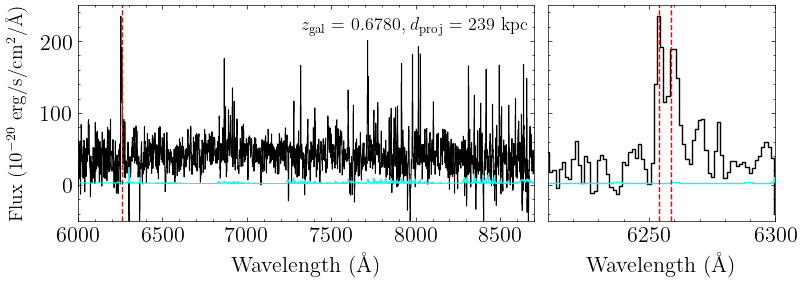

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9,2.8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

axes[0].step(wav_grid[0], gal_spec_raw_grid[0], where='mid', lw=.7)
axes[0].step(wav_grid[0], gal_spec_err_grid[0], where='mid', color='cyan', lw=.7)
axes[0].axvline(3729.875*(1+z_best_list[0]), linestyle='--', lw=1, color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-50, 250)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_grid[0], 
              gal_spec_raw_grid[0], where='mid')
axes[1].step(wav_grid[0], 
              gal_spec_err_grid[0], where='mid', color='cyan')

axes[1].set_xlim(6210, 6300)
axes[1].axvline(3727.092*(1+z_best_list[0]), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+z_best_list[0]), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

axes[0].text(7320, 215, 
             r'$z_\mathrm{gal}=$'+' {:.4f}'.format(z_best_list[0])+r', $d_\mathrm{proj}=$ '+ '{} kpc'.format(d_proj_list[0]), 
             fontsize=13)
#axes[0].text(8000, 150, , fontsize=15)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=0.67545705/z_067_gal.pdf', dpi=300)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

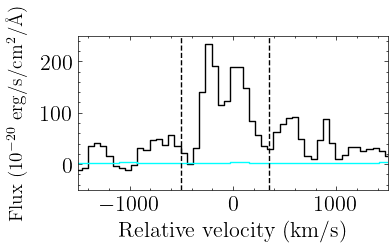

In [10]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(v_grid[0], gal_spec_raw_grid[0], color='black', where='mid')
ax.step(v_grid[0], gal_spec_err_grid[0], color='cyan', where='mid')

ax.set_ylim(-50, 250)
ax.set_xlim(-1500,1500)

ax.axvline(-500, color='black', linestyle='--')
ax.axvline(350, color='black', linestyle='--')

ax.set_xlabel(r'Relative velocity (km/s)')
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [11]:
cont_idx = (((v_grid[0]>=-1500)&(v_grid[0]<=-500))|((v_grid[0]>=800)&(v_grid[0]<=1500)))

In [12]:
x = v_grid[0][cont_idx]
y = gal_spec_raw_grid[0][cont_idx]
dy = gal_spec_err_grid[0][cont_idx]

In [13]:
def get_MLE(x, y, dy):
    
    # Define coefficients
    alpha = np.sum(1/dy**2)
    beta = np.sum(x/dy**2)
    gamma = np.sum(y/dy**2)
    delta = np.sum(x**2/dy**2)
    theta = np.sum(x*y/dy**2)
    
    # Get MLE solutions
    a0 = (gamma*delta - beta*theta)/(alpha*delta - beta**2)
    b0 = (alpha*theta - beta*gamma)/(alpha*delta - beta**2)
    
    return a0, b0

In [14]:
a,b = get_MLE(x,y,dy)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

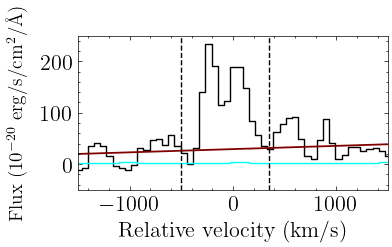

In [15]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(v_grid[0], gal_spec_raw_grid[0], color='black', where='mid')
ax.step(v_grid[0], gal_spec_err_grid[0], color='cyan', where='mid')
ax.plot(v_grid[0], a+b*v_grid[0], lw=1.3, color='maroon')


ax.set_ylim(-50, 250)
ax.set_xlim(-1500,1500)

ax.axvline(-500, color='black', linestyle='--')
ax.axvline(350, color='black', linestyle='--')

ax.set_xlabel(r'Relative velocity (km/s)')
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [22]:
flux_norm = gal_spec_raw_grid[0]/(a+b*v_grid[0])
err_norm = gal_spec_err_grid[0]/(a+b*v_grid[0])

Text(0, 0.5, 'Flux (continuum normalized)')

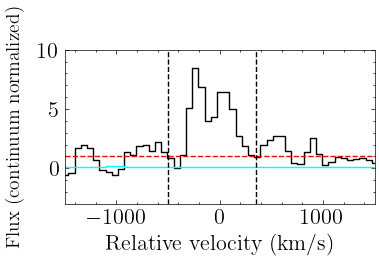

In [23]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(v_grid[0], flux_norm, color='black', where='mid')
ax.step(v_grid[0], err_norm, color='cyan', where='mid')

ax.set_ylim(-3, 10)
ax.set_xlim(-1500,1500)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(-500, color='black', linestyle='--')
ax.axvline(350, color='black', linestyle='--')

#ax.axvline(0, color='black', linestyle='--')

ax.set_xlabel(r'Relative velocity (km/s)')
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

In [24]:
det_idx = (v_grid[0]>=-500)&(v_grid[0]<=350)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
v_det = v_grid[0][det_idx]
dv_det = np.mean(v_det[1:]-v_det[:-1])

In [26]:
3729.875*(np.sum((flux_det[:-1]-1))*dv_det/3e5), 3729.875*((np.sum(err_det[:-1]**2))**.5*dv_det/3e5)

(29.90823099568911, 0.26531897785690034)

# z=1.09

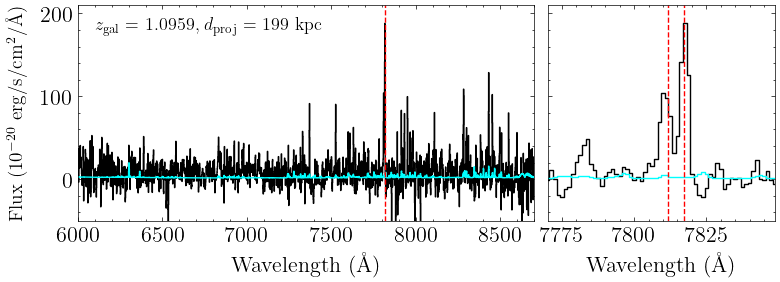

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(9,2.8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

axes[0].step(wav_grid[1], gal_spec_raw_grid[1], where='mid')
axes[0].step(wav_grid[1], gal_spec_err_grid[1], where='mid', color='cyan')
axes[0].text(6100, 180, 
             r'$z_\mathrm{gal}=$'+' {:.4f}'.format(z_best_list[1])+r', $d_\mathrm{proj}=$ '+ '{} kpc'.format(d_proj_list[1]), 
             fontsize=13)
axes[0].axvline(3729.875*(1+z_best_list[1]), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-50, 210)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_grid[1], 
              gal_spec_raw_grid[1], where='mid')
axes[1].step(wav_grid[1], 
              gal_spec_err_grid[1], where='mid', color='cyan')

axes[1].set_xlim(7770, 7849)
axes[1].axvline(3727.092*(1+z_best_list[1]), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+z_best_list[1]), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.09456549/z_109_gal.pdf', dpi=300)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

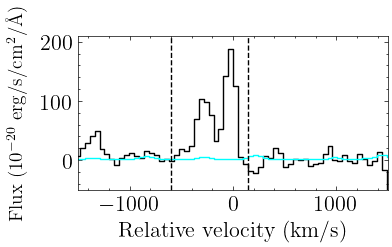

In [41]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(v_grid[1], gal_spec_raw_grid[1], color='black')
ax.step(v_grid[1], gal_spec_err_grid[1], color='cyan')

ax.set_ylim(-50, 210)
ax.set_xlim(-1500,1500)

ax.axvline(-600, color='black', linestyle='--')
ax.axvline(150, color='black', linestyle='--')

ax.set_xlabel(r'Relative velocity (km/s)')
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [42]:
cont_idx = (((v_grid[1]>=-1000)&(v_grid[1]<=-600))|((v_grid[1]>=150)&(v_grid[1]<=700)))

In [43]:
x = v_grid[1][cont_idx]
y = gal_spec_raw_grid[1][cont_idx]
dy = gal_spec_err_grid[1][cont_idx]

In [44]:
a,b = get_MLE(x,y,dy)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

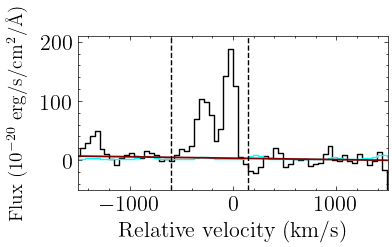

In [45]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(v_grid[1], gal_spec_raw_grid[1], color='black')
ax.step(v_grid[1], gal_spec_err_grid[1], color='cyan')
ax.plot(v_grid[1], a+b*v_grid[1], lw=1.3, color='maroon')

ax.set_ylim(-50, 210)
ax.set_xlim(-1500,1500)

ax.axvline(-600, color='black', linestyle='--')
ax.axvline(150, color='black', linestyle='--')

ax.set_xlabel(r'Relative velocity (km/s)')
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [55]:
a+b*x

array([5.59948114, 5.48535416, 5.37122718, 5.2571002 , 5.14297321,
       5.02884623, 4.91471925, 4.80059227, 2.86043357, 2.74630659,
       2.6321796 , 2.51805262, 2.40392564, 2.28979866, 2.17567168,
       2.06154469, 1.94741771, 1.83329073, 1.71916375])

In [33]:
flux_norm = gal_spec_raw_grid[1]/(a+b*v_grid[1])
err_norm = gal_spec_err_grid[1]/(a+b*v_grid[1])

Text(0, 0.5, 'Flux (continuum normalized)')

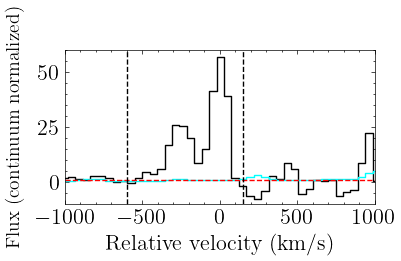

In [36]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(v_grid[1], flux_norm, color='black', where='mid')
ax.step(v_grid[1], err_norm, color='cyan', where='mid')

ax.set_ylim(-10, 60)
ax.set_xlim(-1000,1000)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(-600, color='black', linestyle='--')
ax.axvline(150, color='black', linestyle='--')

#ax.axvline(0, color='black', linestyle='--')

ax.set_xlabel(r'Relative velocity (km/s)')
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

In [37]:
det_idx = (v_grid[1]>=-600)&(v_grid[1]<=150)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
v_det = v_grid[1][det_idx]
dv_det = np.mean(v_det[1:]-v_det[:-1])

In [38]:
3729.875*(np.sum((flux_det[:-1]-1))*dv_det/3e5), 3729.875*((np.sum(err_det[:-1]**2))**.5*dv_det/3e5)

(149.3966570859762, 1.637896080518644)

# Undetected galaxy, z=1.04

In [367]:
qso_spec_arr = np.loadtxt(rootdir+'qso_spec.dat', delimiter='\t')
qso_wav = qso_spec_arr[:,0]
qso_spec = qso_spec_arr[:,1]
qso_spec_err = qso_spec_arr[:,2]

In [368]:
z_abs = 1.04431

(-30.0, 150.0)

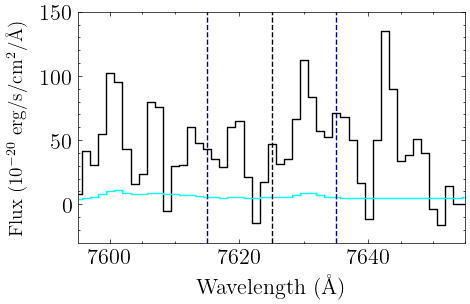

In [374]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, qso_spec, where='mid', color='black')
ax.step(qso_wav, qso_spec_err, where='mid', color='cyan')
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

#ax.axvspan(7700,7800,color='yellow', alpha=.2)
#ax.axvspan(7900,8000,color='yellow', alpha=.2)

ax.set_xlim(3729.875*(1+z_abs)-30,3729.875*(1+z_abs)+30)
ax.set_ylim(-30,150)

In [375]:
3729.875*(1+z_abs)-30, 3729.875*(1+z_abs)-10, 3729.875*(1+z_abs)+10, 3729.875*(1+z_abs)+30

(7595.020761250001, 7615.020761250001, 7635.020761250001, 7655.020761250001)

In [376]:
x = []
y = []
dy = []

for i in range(len(wav_arr)):
    wav = qso_wav[i]
    flux = qso_spec[i]
    err = qso_spec_err[i]
    
    if 7595<=wav<=7615 or 7635<=wav<=7655:
        x.append(wav)
        y.append(flux)
        dy.append(err)
        
x = np.array(x)
y = np.array(y)
dy = np.array(dy)

In [377]:
a,b = get_MLE(x,y,dy)

In [378]:
a,b

(1134.1437665125554, -0.14378491761161008)

(-30.0, 150.0)

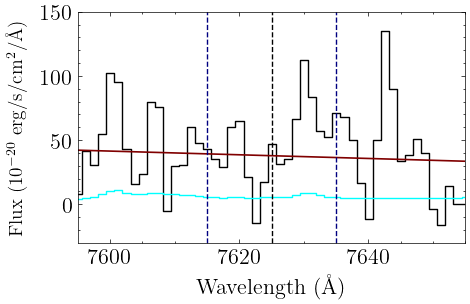

In [379]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, qso_spec, where='mid', color='black')
ax.step(qso_wav, qso_spec_err, where='mid', color='cyan')
ax.plot(qso_wav, a+b*qso_wav, color='maroon', lw=1.2)
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

ax.set_xlim(3729.875*(1+z_abs)-30,3729.875*(1+z_abs)+30)
ax.set_ylim(-30,150)

In [380]:
flux_norm = qso_spec/(a+b*qso_wav)
err_norm = qso_spec_err/(a+b*qso_wav)

(-1.0, 5.0)

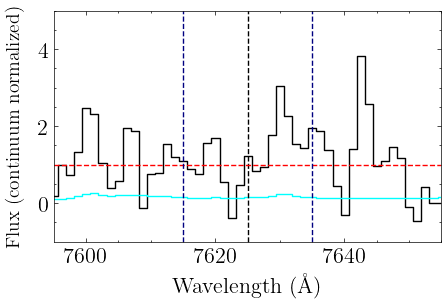

In [382]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, flux_norm, where='mid', color='black')
ax.step(qso_wav, err_norm, where='mid', color='cyan')
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')
ax.axhline(1, linestyle='--', color='red')
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

ax.set_xlim(3729.875*(1+z_abs)-30,3729.875*(1+z_abs)+30)
ax.set_ylim(-1,5)

In [383]:
det_idx = (qso_wav>=7615)&(qso_wav<=7635)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
wav_arr_det = qso_wav[det_idx]
dwav_det = np.mean(wav_arr_det[1:]-wav_arr_det[:-1])

In [384]:
(np.sum((flux_det[:-1]-1))*dwav_det)/(1+z_abs)

1.9821039397199909

In [389]:
(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_abs)

0.39237910334318366

In [390]:
3*(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_abs)

1.1771373100295508

# Undetected galaxy, z=1.16

In [391]:
z_abs = 1.16591

(-30.0, 150.0)

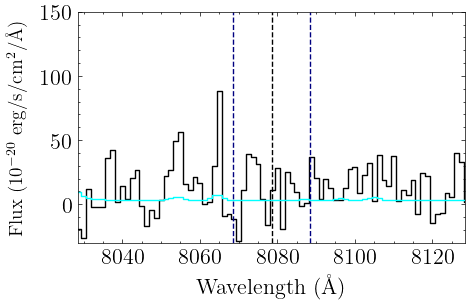

In [397]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, qso_spec, where='mid', color='black')
ax.step(qso_wav, qso_spec_err, where='mid', color='cyan')
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

#ax.axvspan(7700,7800,color='yellow', alpha=.2)
#ax.axvspan(7900,8000,color='yellow', alpha=.2)

ax.set_xlim(3729.875*(1+z_abs)-50,3729.875*(1+z_abs)+50)
ax.set_ylim(-30,150)

In [398]:
3729.875*(1+z_abs)-50, 3729.875*(1+z_abs)-10, 3729.875*(1+z_abs)+10, 3729.875*(1+z_abs)+50

(8028.573561250001, 8068.573561250001, 8088.573561250001, 8128.573561250001)

In [399]:
x = []
y = []
dy = []

for i in range(len(wav_arr)):
    wav = qso_wav[i]
    flux = qso_spec[i]
    err = qso_spec_err[i]
    
    if 8029<=wav<=8069 or 8089<=wav<=8129:
        x.append(wav)
        y.append(flux)
        dy.append(err)
        
x = np.array(x)
y = np.array(y)
dy = np.array(dy)

In [400]:
a,b = get_MLE(x,y,dy)

In [401]:
a,b

(-334.13541733308756, 0.04278851211986713)

(-30.0, 150.0)

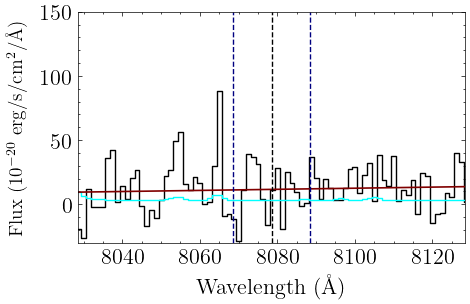

In [402]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, qso_spec, where='mid', color='black')
ax.step(qso_wav, qso_spec_err, where='mid', color='cyan')
ax.plot(qso_wav, a+b*qso_wav, color='maroon', lw=1.2)
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

ax.set_xlim(3729.875*(1+z_abs)-50,3729.875*(1+z_abs)+50)
ax.set_ylim(-30,150)

In [403]:
flux_norm = qso_spec/(a+b*qso_wav)
err_norm = qso_spec_err/(a+b*qso_wav)

(-1.0, 5.0)

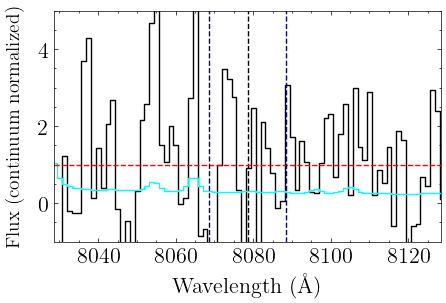

In [404]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, flux_norm, where='mid', color='black')
ax.step(qso_wav, err_norm, where='mid', color='cyan')
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')
ax.axhline(1, linestyle='--', color='red')
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

ax.set_xlim(3729.875*(1+z_abs)-50,3729.875*(1+z_abs)+50)
ax.set_ylim(-1,5)

In [405]:
det_idx = (qso_wav>=8069)&(qso_wav<=8089)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
wav_arr_det = qso_wav[det_idx]
dwav_det = np.mean(wav_arr_det[1:]-wav_arr_det[:-1])

In [406]:
(np.sum((flux_det[:-1]-1))*dwav_det)/(1+z_abs)

-1.2520405504572945

In [407]:
(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_abs)

0.6718730707498229

In [408]:
3*(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_abs)

2.015619212249469

# Undetected galaxy, z=1.26

In [424]:
z_abs = 1.25937

(-30.0, 150.0)

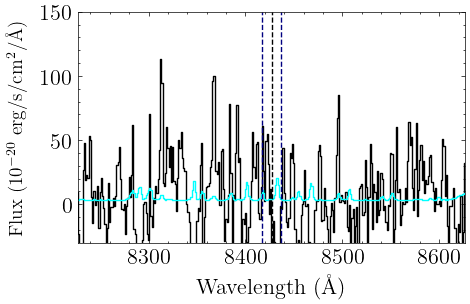

In [431]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, qso_spec, where='mid', color='black')
ax.step(qso_wav, qso_spec_err, where='mid', color='cyan')
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

#ax.axvspan(7700,7800,color='yellow', alpha=.2)
#ax.axvspan(7900,8000,color='yellow', alpha=.2)

ax.set_xlim(3729.875*(1+z_abs)-200,3729.875*(1+z_abs)+200)
ax.set_ylim(-30,150)

In [432]:
3729.875*(1+z_abs)-200, 3729.875*(1+z_abs)-10, 3729.875*(1+z_abs)+10, 3729.875*(1+z_abs)+200

(8227.16767875, 8417.16767875, 8437.16767875, 8627.16767875)

In [433]:
x = []
y = []
dy = []

for i in range(len(wav_arr)):
    wav = qso_wav[i]
    flux = qso_spec[i]
    err = qso_spec_err[i]
    
    if 8227<=wav<=8417 or 8437<=wav<=8627:
        x.append(wav)
        y.append(flux)
        dy.append(err)
        
x = np.array(x)
y = np.array(y)
dy = np.array(dy)

In [434]:
a,b = get_MLE(x,y,dy)

In [435]:
a,b

(16.70945775908027, -0.0009841816949788915)

(-30.0, 150.0)

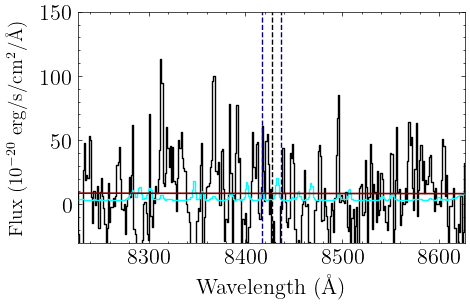

In [437]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, qso_spec, where='mid', color='black')
ax.step(qso_wav, qso_spec_err, where='mid', color='cyan')
ax.plot(qso_wav, a+b*qso_wav, color='maroon', lw=1.2)
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

ax.set_xlim(3729.875*(1+z_abs)-200,3729.875*(1+z_abs)+200)
ax.set_ylim(-30,150)

In [438]:
flux_norm = qso_spec/(a+b*qso_wav)
err_norm = qso_spec_err/(a+b*qso_wav)

(-1.0, 10.0)

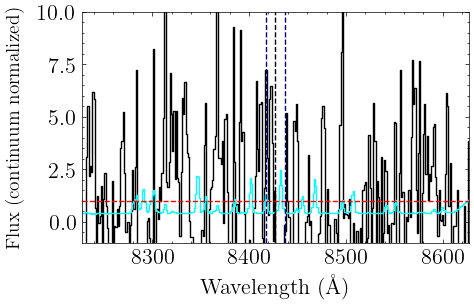

In [439]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(qso_wav, flux_norm, where='mid', color='black')
ax.step(qso_wav, err_norm, where='mid', color='cyan')
ax.axvline(3729.875*(1+z_abs), color='black', linestyle='--')
ax.axhline(1, linestyle='--', color='red')
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

ax.axvline(3729.875*(1+z_abs)-10, color='navy', linestyle='--')
ax.axvline(3729.875*(1+z_abs)+10, color='navy', linestyle='--')

ax.set_xlim(3729.875*(1+z_abs)-200,3729.875*(1+z_abs)+200)
ax.set_ylim(-1,10)

In [440]:
det_idx = (qso_wav>=8417)&(qso_wav<=8437)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
wav_arr_det = qso_wav[det_idx]
dwav_det = np.mean(wav_arr_det[1:]-wav_arr_det[:-1])

In [441]:
(np.sum((flux_det[:-1]-1))*dwav_det)/(1+z_abs)

-15.859271781092904

In [442]:
(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_abs)

2.331336494176375

In [443]:
3*(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_abs)

6.994009482529124

# z=0.67

In [69]:
x = []
y = []
dy = []

for i in range(len(wav_arr)):
    wav = wav_arr[i]
    flux = spec_gal[i]
    err = err_gal[i]
    
    if 6050<=wav<=6250 or 6266<=wav<=6466:
        x.append(wav)
        y.append(flux)
        dy.append(err)
        
x = np.array(x)
y = np.array(y)
dy = np.array(dy)

In [70]:
def get_MLE(x, y, dy):
    
    # Define coefficients
    alpha = np.sum(1/dy**2)
    beta = np.sum(x/dy**2)
    gamma = np.sum(y/dy**2)
    delta = np.sum(x**2/dy**2)
    theta = np.sum(x*y/dy**2)
    
    # Get MLE solutions
    a0 = (gamma*delta - beta*theta)/(alpha*delta - beta**2)
    b0 = (alpha*theta - beta*gamma)/(alpha*delta - beta**2)
    
    return a0, b0

In [71]:
a,b = get_MLE(x,y,dy)

(-20.0, 350.0)

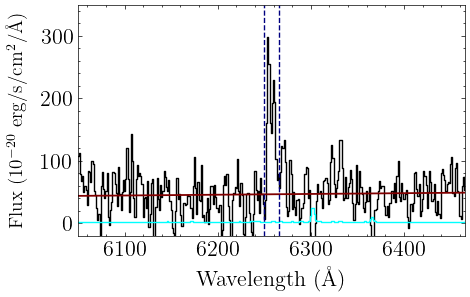

In [72]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')
ax.plot(wav_arr, a+b*wav_arr, lw=1.3, color='maroon')


#ax.axvline(3727.092*(1+z_gal), linestyle='--', color='red')
#ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(6250, linestyle='--', color='navy')
ax.axvline(6266, linestyle='--', color='navy')

ax.axvspan(7600,7630, color='yellow', alpha=.2)
ax.axvspan(7880,7995, color='yellow', alpha=.2)

ax.set_xlim(6050, 6466)
ax.set_ylim(-20, 350)

In [73]:
flux_norm = spec_gal/(a+b*wav_arr)
err_norm = err_gal/(a+b*wav_arr)

Text(0, 0.5, 'Flux (continuum normalized)')

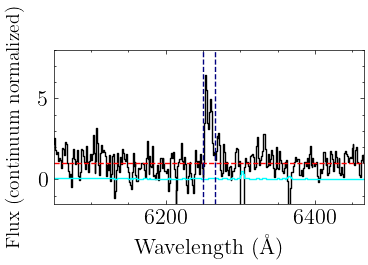

In [74]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(wav_arr, flux_norm, color='black', where='mid')
ax.step(wav_arr, err_norm, color='cyan', where='mid')

ax.set_xlim(6050, 6466)
ax.set_ylim(-1.5, 8)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(6250, linestyle='--', color='navy')
ax.axvline(6266, linestyle='--', color='navy')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux (continuum normalized)')

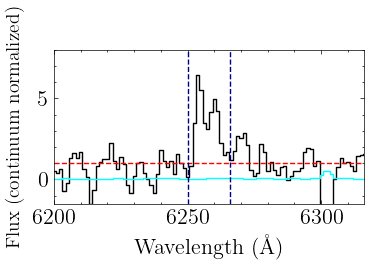

In [75]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(wav_arr, flux_norm, color='black', where='mid')
ax.step(wav_arr, err_norm, color='cyan', where='mid')

ax.set_xlim(6200, 6266+50)
ax.set_ylim(-1.5, 8)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(6250, linestyle='--', color='navy')
ax.axvline(6266, linestyle='--', color='navy')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

In [76]:
det_idx = (wav_arr>=6250)&(wav_arr<=6266)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
wav_arr_det = wav_arr[det_idx]
dwav_det = np.mean(wav_arr_det[1:]-wav_arr_det[:-1])

In [77]:
(np.sum((flux_det[:-1]-1))*dwav_det)/(1+z_gal)

20.821585816728643

In [78]:
(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_gal)

0.15794330866304562

# z=1.09

In [105]:
x = []
y = []
dy = []

for i in range(len(wav_arr)):
    wav = wav_arr[i]
    flux = spec_gal[i]
    err = err_gal[i]
    
    if 7630<=wav<=7800 or 7825<=wav<=7880 or 7995<=wav<=8025:
        x.append(wav)
        y.append(flux)
        dy.append(err)
        
x = np.array(x)
y = np.array(y)
dy = np.array(dy)

In [106]:
a,b = get_MLE(x,y,dy)

(-50.0, 260.0)

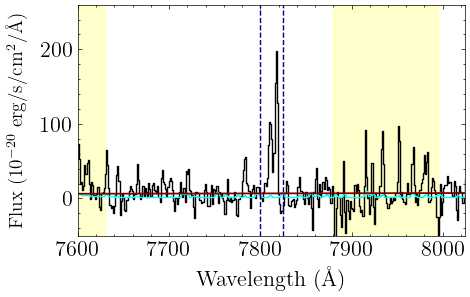

In [107]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')
ax.plot(wav_arr, a+b*wav_arr, lw=1.3, color='maroon')


#ax.axvline(3727.092*(1+z_gal), linestyle='--', color='red')
#ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(7800, linestyle='--', color='navy')
ax.axvline(7825, linestyle='--', color='navy')

ax.axvspan(7600,7630, color='yellow', alpha=.2)
ax.axvspan(7880,7995, color='yellow', alpha=.2)

ax.set_xlim(7600, 8025)
ax.set_ylim(-50, 260)

In [108]:
flux_norm = spec_gal/(a+b*wav_arr)
err_norm = err_gal/(a+b*wav_arr)

Text(0, 0.5, 'Flux (continuum normalized)')

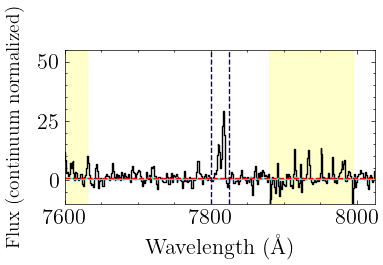

In [109]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(wav_arr, flux_norm, color='black', where='mid')
ax.step(wav_arr, err_norm, color='cyan', where='mid')

ax.set_ylim(-10, 55)
ax.set_xlim(7600, 8025)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(7800, linestyle='--', color='navy')
ax.axvline(7825, linestyle='--', color='navy')

ax.axvspan(7600,7630, color='yellow', alpha=.2)
ax.axvspan(7880,7995, color='yellow', alpha=.2)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux (continuum normalized)')

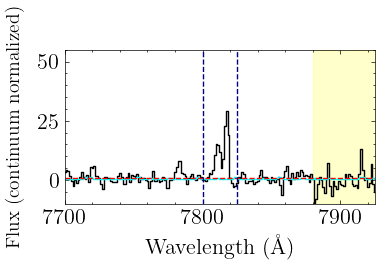

In [110]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(wav_arr, flux_norm, color='black', where='mid')
ax.step(wav_arr, err_norm, color='cyan', where='mid')

ax.set_ylim(-10, 55)
ax.set_xlim(7700, 7925)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(7800, linestyle='--', color='navy')
ax.axvline(7825, linestyle='--', color='navy')

ax.axvspan(7600,7630, color='yellow', alpha=.2)
ax.axvspan(7880,7995, color='yellow', alpha=.2)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

In [111]:
det_idx = (wav_arr>=7800)&(wav_arr<=7825)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
wav_arr_det = wav_arr[det_idx]
dwav_det = np.mean(wav_arr_det[1:]-wav_arr_det[:-1])

In [112]:
(np.sum((flux_det[:-1]-1))*dwav_det)/(1+z_gal)

75.13204104766278

In [113]:
(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_gal)

1.162906188152203

# z=1.22

In [134]:
x = []
y = []
dy = []

for i in range(len(wav_arr)):
    wav = wav_arr[i]
    flux = spec_gal[i]
    err = err_gal[i]
    
    if 8093<=wav<=8270 or 8320<=wav<=8340 or 8360<=wav<=8420 or 8460<=wav<=8508: 
        x.append(wav)
        y.append(flux)
        dy.append(err)
        
x = np.array(x)
y = np.array(y)
dy = np.array(dy)

In [135]:
a,b = get_MLE(x,y,dy)

(-40.0, 550.0)

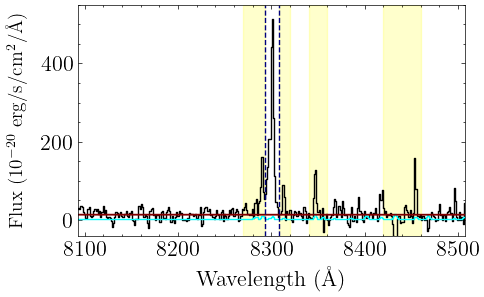

In [136]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')

ax.plot(wav_arr, a+b*wav_arr, lw=1.3, color='maroon')


#ax.axvline(3727.092*(1+z_gal), linestyle='--', color='red')
#ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(8293, linestyle='--', color='navy')
ax.axvline(8308, linestyle='--', color='navy')

ax.axvspan(8270,8293, color='yellow', alpha=.2)
ax.axvspan(8308,8320, color='yellow', alpha=.2)
ax.axvspan(8340,8360, color='yellow', alpha=.2)
ax.axvspan(8420,8460, color='yellow', alpha=.2)

ax.set_xlim(8293-200, 8308+200)
ax.set_ylim(-40, 550)

(-40.0, 550.0)

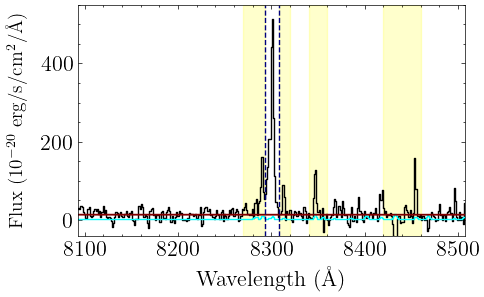

In [137]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')
ax.plot(wav_arr, a+b*wav_arr, lw=1.3, color='maroon')


#ax.axvline(3727.092*(1+z_gal), linestyle='--', color='red')
#ax.axvline(3729.875*(1+z_gal), linestyle='--', color='red')

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(8293, linestyle='--', color='navy')
ax.axvline(8308, linestyle='--', color='navy')

ax.axvspan(8270,8293, color='yellow', alpha=.2)
ax.axvspan(8308,8320, color='yellow', alpha=.2)
ax.axvspan(8340,8360, color='yellow', alpha=.2)
ax.axvspan(8420,8460, color='yellow', alpha=.2)


ax.axvspan(7600,7630, color='yellow', alpha=.2)
ax.axvspan(7880,7995, color='yellow', alpha=.2)

ax.set_xlim(8293-200, 8308+200)
ax.set_ylim(-40, 550)

In [138]:
flux_norm = spec_gal/(a+b*wav_arr)
err_norm = err_gal/(a+b*wav_arr)

Text(0, 0.5, 'Flux (continuum normalized)')

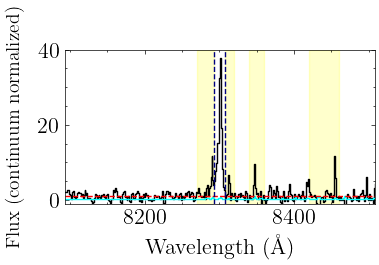

In [139]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(wav_arr, flux_norm, color='black', where='mid')
ax.step(wav_arr, err_norm, color='cyan', where='mid')

ax.set_xlim(8293-200, 8308+200)
ax.set_ylim(-1, 40)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(8293, linestyle='--', color='navy')
ax.axvline(8308, linestyle='--', color='navy')

ax.axvspan(8270,8293, color='yellow', alpha=.2)
ax.axvspan(8308,8320, color='yellow', alpha=.2)
ax.axvspan(8340,8360, color='yellow', alpha=.2)
ax.axvspan(8420,8460, color='yellow', alpha=.2)


ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux (continuum normalized)')

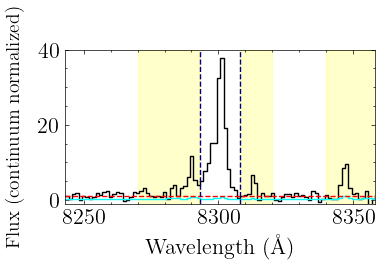

In [140]:
fig, ax = plt.subplots(1,figsize=(4,2))

ax.step(wav_arr, flux_norm, color='black', where='mid')
ax.step(wav_arr, err_norm, color='cyan', where='mid')

ax.set_xlim(8293-50, 8308+50)
ax.set_ylim(-1, 40)
ax.axhline(1, color='red', linestyle='--')

ax.axvline(8293, linestyle='--', color='navy')
ax.axvline(8308, linestyle='--', color='navy')

ax.axvspan(8270,8293, color='yellow', alpha=.2)
ax.axvspan(8308,8320, color='yellow', alpha=.2)
ax.axvspan(8340,8360, color='yellow', alpha=.2)
ax.axvspan(8420,8460, color='yellow', alpha=.2)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)

In [141]:
det_idx = (wav_arr>=8293)&(wav_arr<=8308)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
wav_arr_det = wav_arr[det_idx]
dwav_det = np.mean(wav_arr_det[1:]-wav_arr_det[:-1])

In [142]:
(np.sum((flux_det[:-1]-1))*dwav_det)/(1+z_gal)

81.79081125403373

In [143]:
(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_gal)

0.7473607397661439

# z=1.27

In [141]:
x = []
y = []
dy = []

for i in range(len(wav_arr)):
    wav = wav_arr[i]
    flux = spec_gal[i]
    err = err_gal[i]
    
    if 8185<=wav<=8250 or 8560<=wav<=8595 or 8715<=wav<=8750: 
        x.append(wav)
        y.append(flux)
        dy.append(err)
        
x = np.array(x)
y = np.array(y)
dy = np.array(dy)

In [142]:
a,b = get_MLE(x,y,dy)

(-10.0, 180.0)

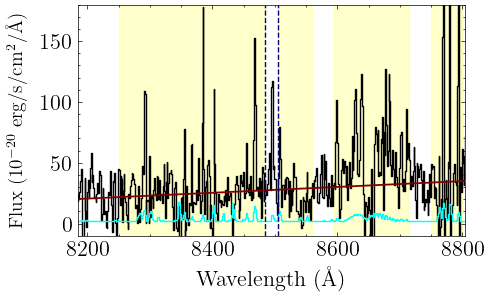

In [143]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              spec_gal, where='mid')
ax.step(wav_arr, 
              err_gal, where='mid', color='cyan')
ax.plot(wav_arr, a+b*wav_arr, lw=1.3, color='maroon')


ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

ax.axvline(8485, linestyle='--', color='navy')
ax.axvline(8505, linestyle='--', color='navy')

ax.axvspan(8250,8485, color='yellow', alpha=.2)
ax.axvspan(8505,8560, color='yellow', alpha=.2)
ax.axvspan(8595,8715, color='yellow', alpha=.2)
ax.axvspan(8750,8800, color='yellow', alpha=.2)

ax.set_xlim(8485-300, 8505+300)
ax.set_ylim(-10, 180)

In [144]:
flux_norm = spec_gal/(a+b*wav_arr)
err_norm = err_gal/(a+b*wav_arr)

(-1.0, 5.0)

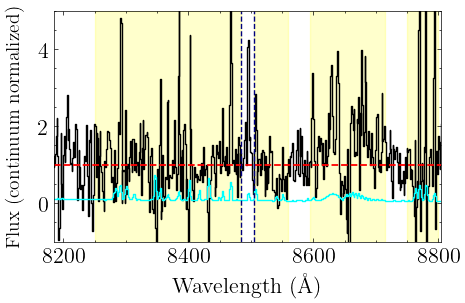

In [145]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              flux_norm, where='mid')
ax.step(wav_arr, 
              err_norm, where='mid', color='cyan')
ax.plot(wav_arr, a+b*wav_arr, lw=1.3, color='maroon')

ax.axhline(1, linestyle='--', color='red', lw=1.3)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)
ax.axvline(8485, linestyle='--', color='navy')
ax.axvline(8505, linestyle='--', color='navy')

ax.axvspan(8250,8485, color='yellow', alpha=.2)
ax.axvspan(8505,8560, color='yellow', alpha=.2)
ax.axvspan(8595,8715, color='yellow', alpha=.2)
ax.axvspan(8750,8800, color='yellow', alpha=.2)

ax.set_xlim(8485-300, 8505+300)
ax.set_ylim(-1, 5)

(-1.0, 5.0)

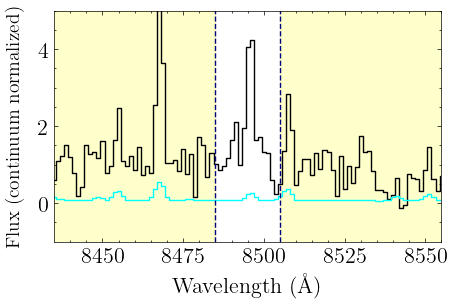

In [146]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, 
              flux_norm, where='mid')
ax.step(wav_arr, 
              err_norm, where='mid', color='cyan')
ax.plot(wav_arr, a+b*wav_arr, lw=1.3, color='maroon')


ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux (continuum normalized)', fontsize=14, labelpad=10)
ax.axvline(8485, linestyle='--', color='navy')
ax.axvline(8505, linestyle='--', color='navy')

ax.axvspan(8250,8485, color='yellow', alpha=.2)
ax.axvspan(8505,8560, color='yellow', alpha=.2)
ax.axvspan(8595,8715, color='yellow', alpha=.2)
ax.axvspan(8750,8800, color='yellow', alpha=.2)

ax.set_xlim(8485-50, 8505+50)
ax.set_ylim(-1, 5)

In [147]:
det_idx = (wav_arr>=8485)&(wav_arr<=8505)
flux_det = flux_norm[det_idx]
err_det = err_norm[det_idx]
wav_arr_det = wav_arr[det_idx]
dwav_det = np.mean(wav_arr_det[1:]-wav_arr_det[:-1])

In [148]:
(np.sum((flux_det[:-1]-1))*dwav_det)/(1+z_gal)

5.831038315246375

In [149]:
(np.sqrt(np.sum(err_det[:-1]**2))*dwav_det)/(1+z_gal)

0.27425837592213476